# import model

# Draft 1

In [65]:
# -*- coding: utf-8 -*-

# import statements
from scipy.constants import minute
from math import inf
import json
import cobra
import re

# import enzyme kinetics and rate equations
with open('../sabio_proccessed.json', 'rb') as f:
    reaction_kinetics = json.load(f)
    
def average(num_1, num_2 = None):
    if num_2 is not None:
        numbers = [num_1, num_2]
        average = sum(numbers) / len(numbers)
        return average
    else:
        return num_1
    
empty = ['', '-', None]
    
    
# define chemical concentrations
class dynamicFBA():
    def __init__(self, model, total_time, timestep, initial_concentrations):
        self.model = model
        self.parameters = {}
        self.variables = {}
        
        self.parameters['total_time'] = total_time * minute
        self.parameters['timestep'] = timestep * minute
        self.parameters['initial_concentrations'] = initial_concentrations
        self.variables['time_series'] = {}
        self.variables['concentrations'] = {}
        for metabolite in self.model.metabolites:
            self.variables['time_series'][metabolite.name] = []

    def simulate(self, temperature = 25, p_h = 7):
        self.variables['elapsed_time'] = 0
        #Simulate for each timestep within total time frame
        timesteps = round(self.parameters['total_time']/self.parameters['timestep'])
        for timestep in range(timesteps):
            if timestep == 0:
                self.calculate_kinetics(self.parameters['initial_concentrations'],temperature = 25, p_h = 7)
            else:
                self.calculate_kinetics(self.variables['concentrations'],temperature = 25, p_h = 7)
            
            #Calcuate and parameterize fluxes from michaelis-menten kinetics

            for reaction in self.model.reactions:
                if reaction.name in self.parameters['calculated_rate_laws']:
                    kinetic_flux = self.parameters['calculated_rate_laws'][reaction.name]
                    print(kinetic_flux)
                    self.set_constraints(reaction, reaction.name,kinetic_flux)
                elif reaction.id in self.parameters['calculated_rate_laws']:
                    kinetic_flux = self.parameters['calculated_rate_laws'][reaction.id]
                    self.set_constraints(reaction, reaction.id,kinetic_flux)
                else:
                    print(f'--> ERROR: The {reaction.name} reaction is not defined in the kinetics data.')                    

            # execute the model and update concentrations
            solution = self.model.optimize()
            self.update_concentrations(solution)
            
            # visualize changing concentrations
#             metabolites = []
#             self.visualize(metabolites)

            self.variables['elapsed_time'] += timestep
            print(f'{timestep}/{timesteps}', end='\r')
    
    def calculate_kinetics(self,concentrations, temperature = 25, p_h = 7):
        self.parameters['calculated_rate_laws'] = {}

        for enzyme in reaction_kinetics:
            reactions = {}

            for reaction in reaction_kinetics[enzyme]:           
                minimum = inf
                for entry_id in reaction_kinetics[enzyme][reaction]:
                    if "SubstitutedRateLaw" in reaction_kinetics[enzyme][reaction][entry_id]:
                        remainder = re.sub('([0-9]|[ABC]|\/|\(|\)|\+|\.|\*|)', '', reaction_kinetics[enzyme][reaction][entry_id]["SubstitutedRateLaw"])
                        if remainder == '':
                            A = 0
                            B = 0
                            C = 0

                            if "A" in reaction_kinetics[enzyme][reaction][entry_id]["Parameters"]:   
                                if reaction_kinetics[enzyme][reaction][entry_id]["Parameters"]["A"]["species"] in current_chemical_concentrations:    
                                    A = concentrations[reaction_kinetics[enzyme][reaction][entry_id]["Parameters"]["A"]["species"]]

                            if "B" in reaction_kinetics[enzyme][reaction][entry_id]["Parameters"]:   
                                if reaction_kinetics[enzyme][reaction][entry_id]["Parameters"]["B"]["species"] in current_chemical_concentrations:    
                                    B = concentrations[reaction_kinetics[enzyme][reaction][entry_id]["Parameters"]["B"]["species"]]

                            if "C" in reaction_kinetics[enzyme][reaction][entry_id]["Parameters"]:   
                                if reaction_kinetics[enzyme][reaction][entry_id]["Parameters"]["C"]["species"] in current_chemical_concentrations:    
                                    C = concentrations[reaction_kinetics[enzyme][reaction][entry_id]["Parameters"]["C"]["species"]]

                            try:
                                flux = eval(reaction_kinetics[enzyme][reaction][entry_id]["SubstitutedRateLaw"])
                            except:
                                pass
                            
                            # define the proximity of the entryID from the parameterized conditions
                            if (temperature and reaction_kinetics[enzyme][reaction][entry_id]["Temperature"]) not in empty:
                                temperature_deviation = abs(temperature - float(reaction_kinetics[enzyme][reaction][entry_id]["Temperature"]))/temperature
                            else:
                                temperature_deviation = 0
                            if (p_h and reaction_kinetics[enzyme][reaction][entry_id]["pH"]) not in empty:
                                ph_deviation = abs(p_h - float(reaction_kinetics[enzyme][reaction][entry_id]["pH"]))/p_h
                            else:
                                ph_deviation = 0
                                
                            deviation = average(temperature_deviation, ph_deviation)
                            minimum = min(deviation, minimum)

                            # define the entryID content
                            if deviation == minimum:
                                self.parameters['calculated_rate_laws'][enzyme] = flux

    def set_constraints(self,reaction,reaction_name,constant):
        expression = reaction.flux_expression
        reaction_name = re.sub('\s', '_', reaction_name)
        print(constant)
        constraint = self.model.problem.Constraint(
                expression,lb=constant,ub=constant,name=f'{reaction_name}_kinetics'
            )
        self.model.add_cons_vars(constraint)
        self.model.solver.update()

    def update_concentrations(self, solution):
        for metabolite in self.model.metabolites:
            for reaction in self.model.reactions:
                if metabolite in reaction.metabolites:
                    if metabolite.name in self.variables['concentrations']:
                        self.variables['concentrations'][metabolite.name] += reaction.metabolites[metabolite] * solution.fluxes[reaction.id]
                        self.log(metabolite.name)
                    elif metabolite.id in self.variables['concentrations']:
                        self.variables['concentrations'][metabolite.id] += reaction.metabolites[metabolite] * solution.fluxes[reaction.id]
                        self.log(metabolite.id)
                    else:
                        print(f'--> ERROR: Neither the id <{metabolite.id}> nor the name < {metabolite.name} > are recognized by the code.')
                        
    def log(self, metabolite_name):
        self.variables['time_series'][metabolite_name].append({self.variables['elapsed_time']:self.variables['concentrations'][metabolite_name]})
            
#     def visualize(self, metabolites):
#         for metabolite in metabolites:
#             self.variables['concentrations'][metabolite.name]

In [66]:
import cobra 

# define in the initial conditions
current_chemical_concentrations = {"ATP":200, "ADP":100}
total_time = 100
timestep = 1

# import the cobra model
model = cobra.io.read_sbml_model('../iSB619.xml')

# execute the package
dfba = dynamicFBA(model, total_time, timestep,current_chemical_concentrations)
dfba.simulate()
print(dfba.variables['concentrations']['adp'])

--> ERROR: The Adenosylmethionine decarboxylase reaction is not defined in the kinetics data.
--> ERROR: The CO2 transporter via diffusion reaction is not defined in the kinetics data.
--> ERROR: The Cytosine transport in via proton symport reaction is not defined in the kinetics data.
--> ERROR: The L-cysteine transport via ABC system reaction is not defined in the kinetics data.
--> ERROR: The Diaminopimelate epimerase reaction is not defined in the kinetics data.
--> ERROR: The 2,3-diketo-5-methylthio-1-phosphopentane degradation reaction reaction is not defined in the kinetics data.
--> ERROR: The 2 3 diketo 5 methylthio 1 phosphopentane degradation reaction reaction is not defined in the kinetics data.
--> ERROR: The D lactate transport via proton symport reaction is not defined in the kinetics data.
4.14494382022472
4.14494382022472
0.0
0.0
--> ERROR: The Ethanol reversible transport reaction is not defined in the kinetics data.
--> ERROR: The Meso-2,6-Diaminoheptanedioate exchan

--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the name < H+ > are recognized by the code.
--> ERROR: Neither the id <h_c> nor the 

KeyError: 'ADP'

# Brainstorming

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


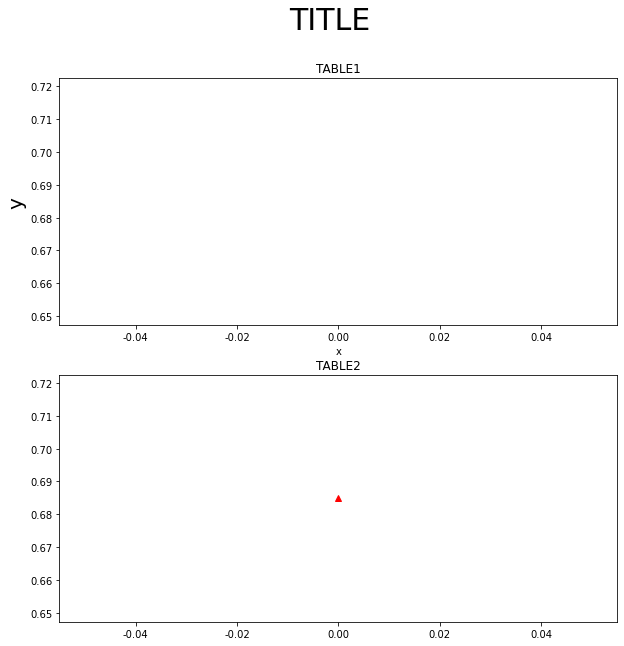

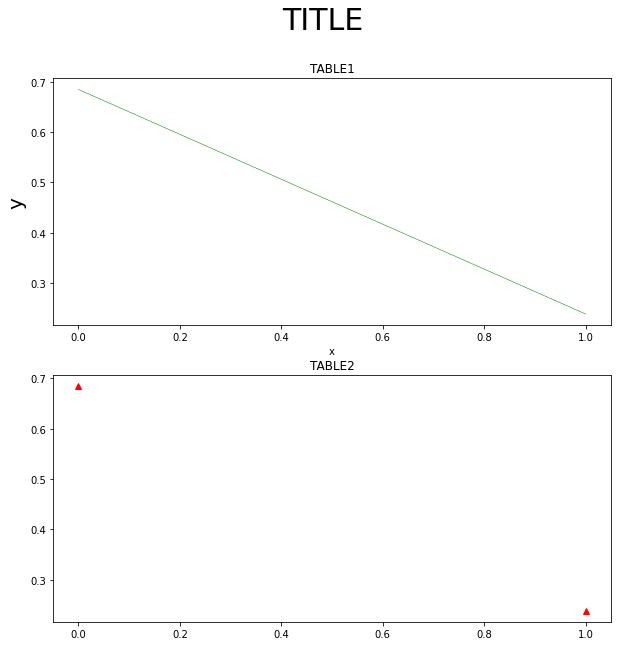

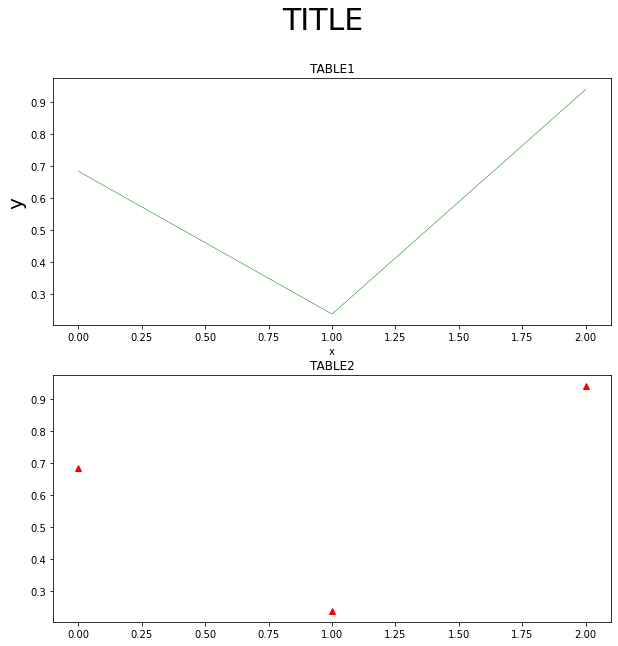

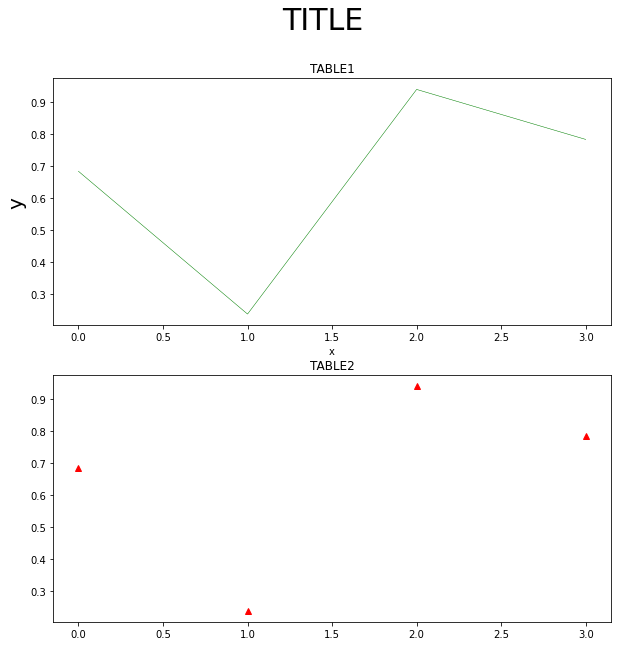

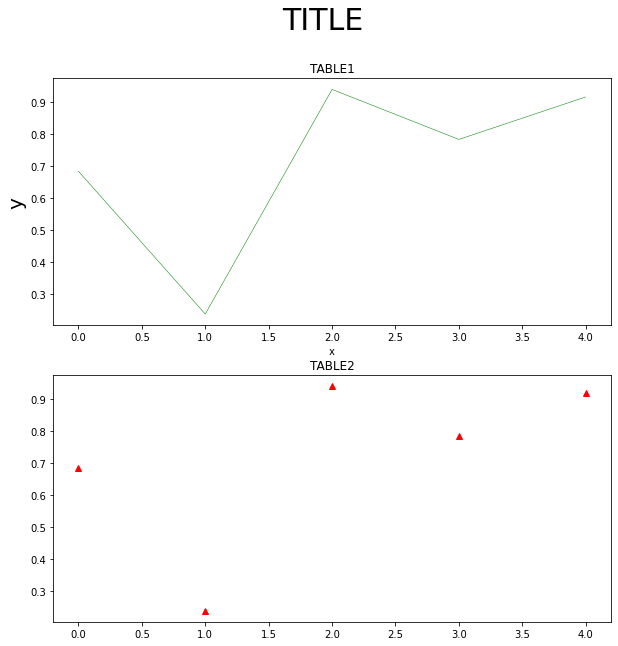

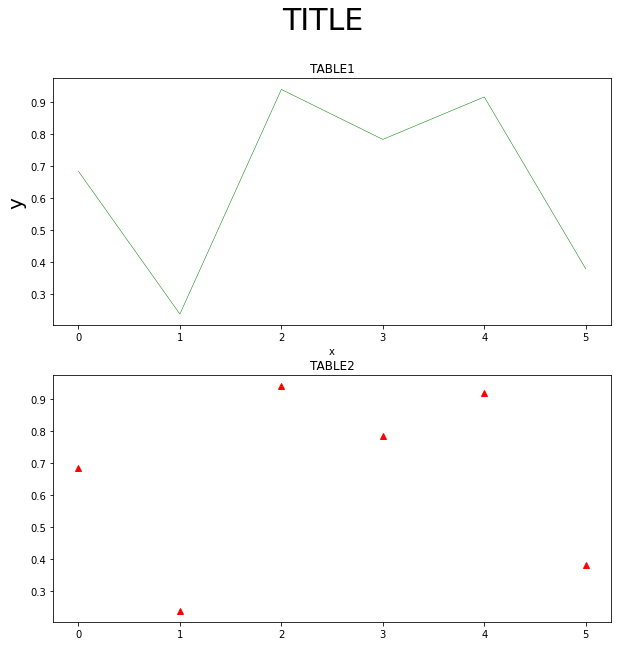

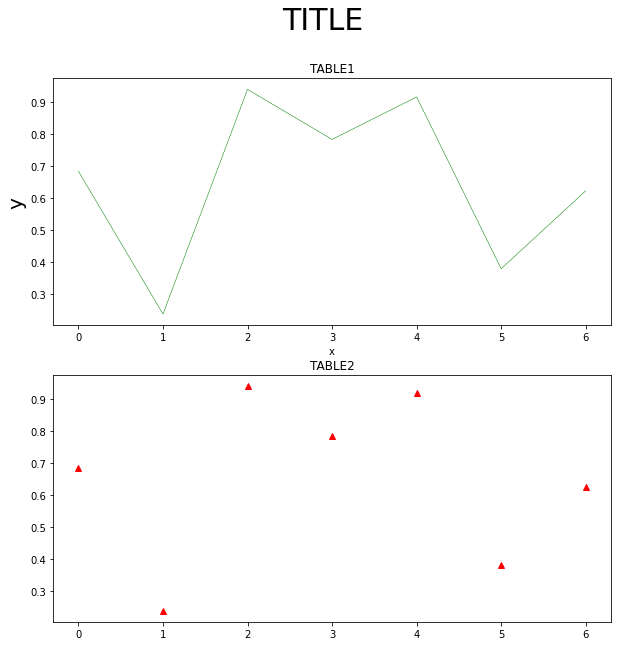

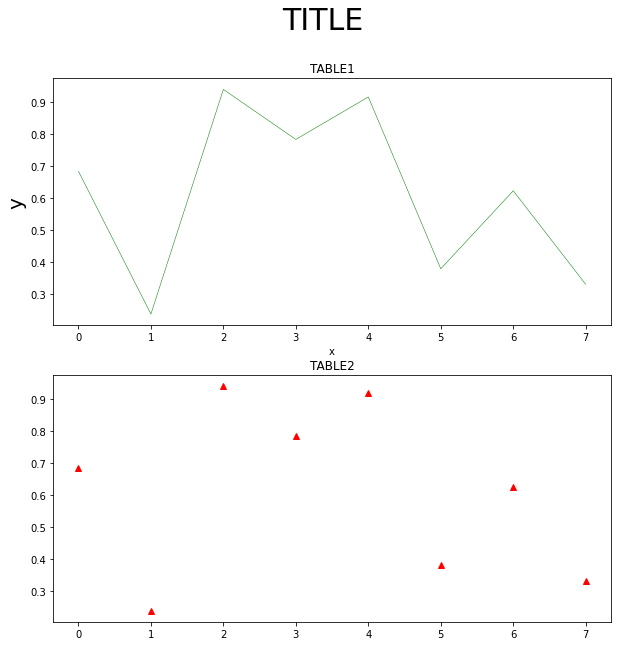

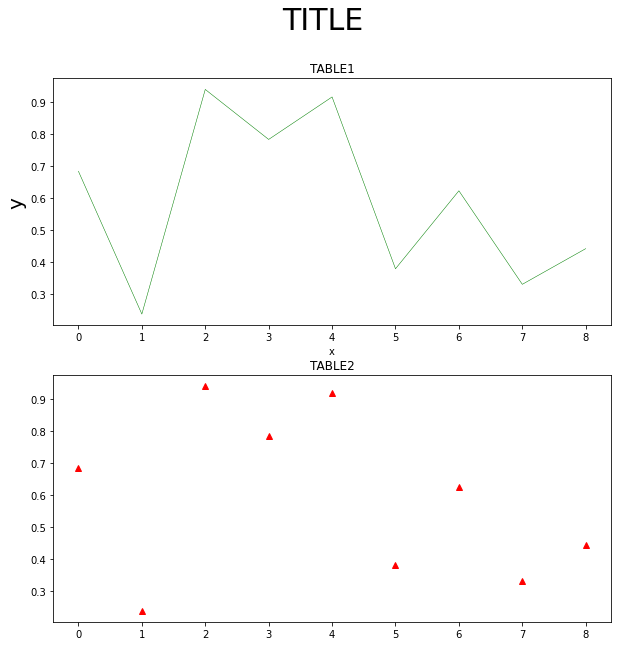

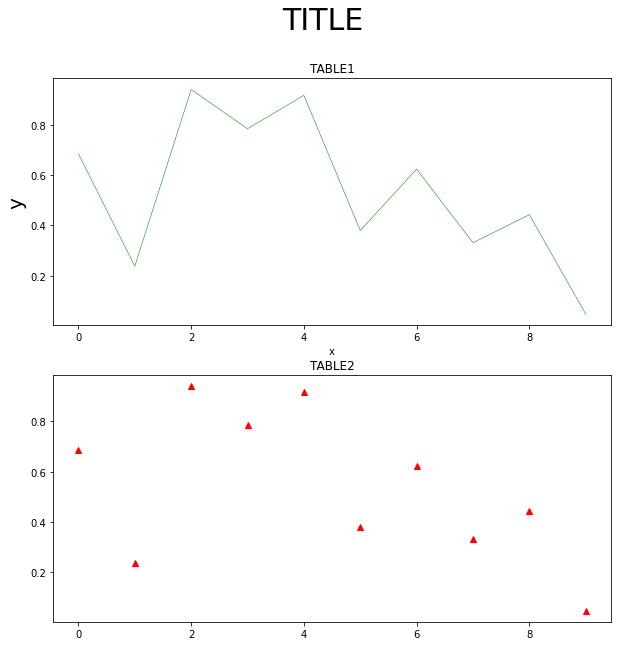

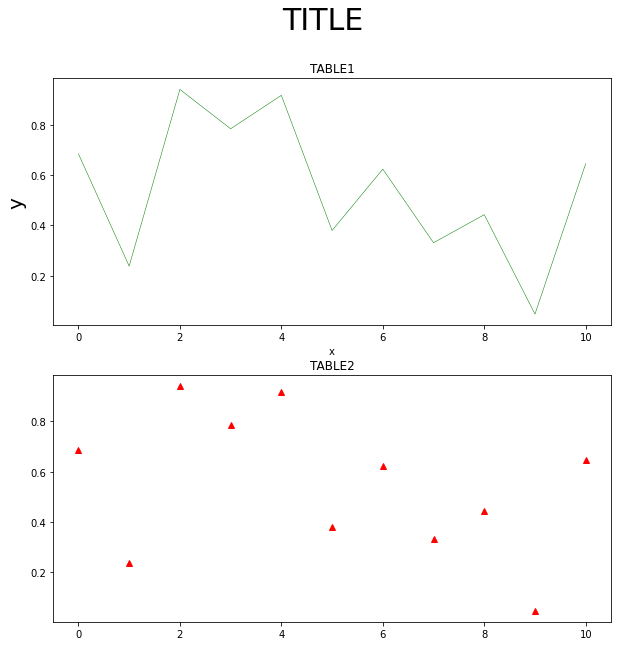

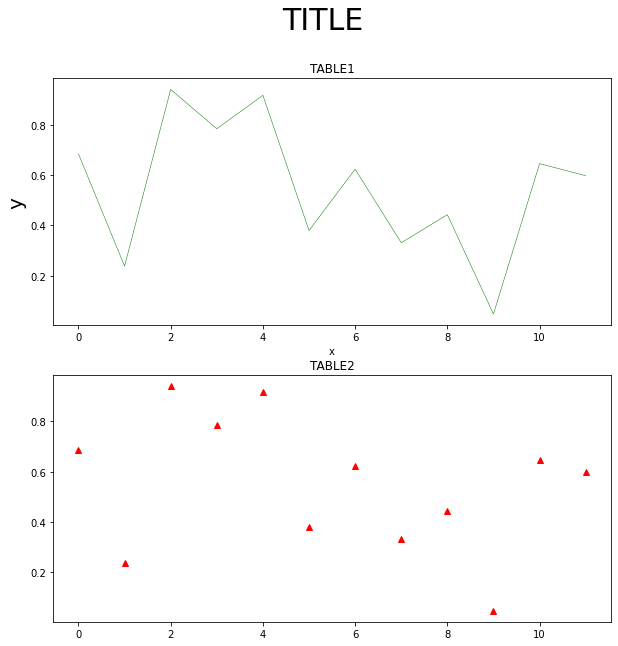

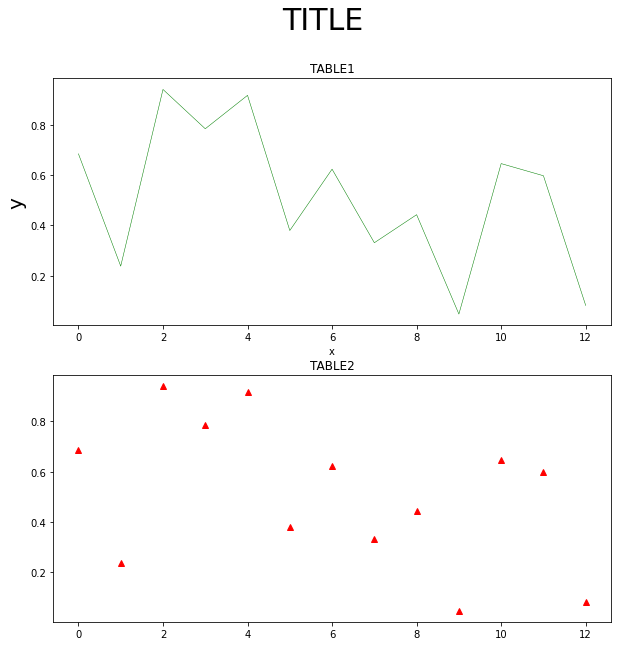

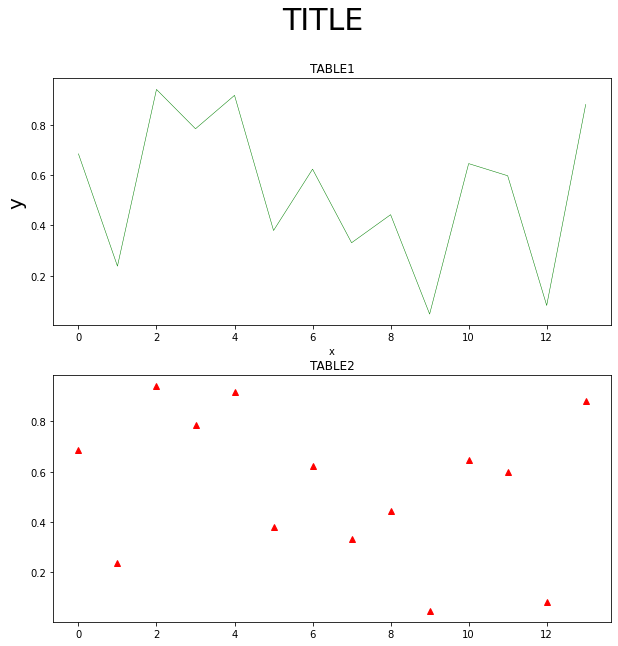

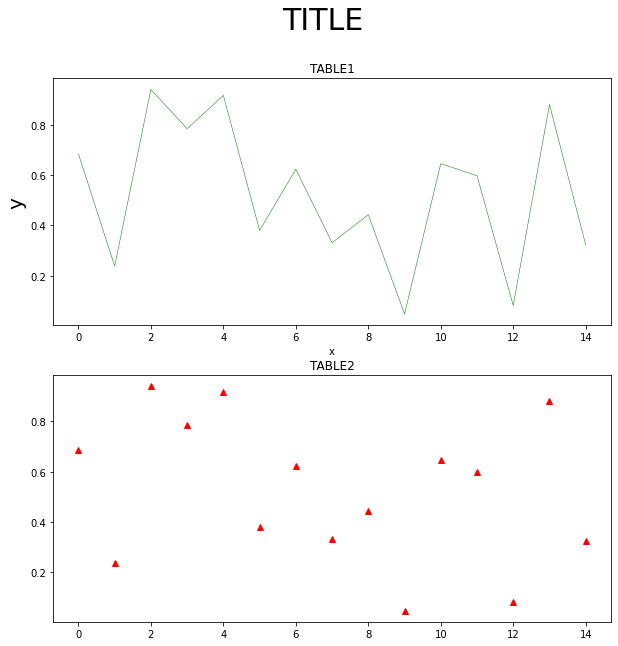

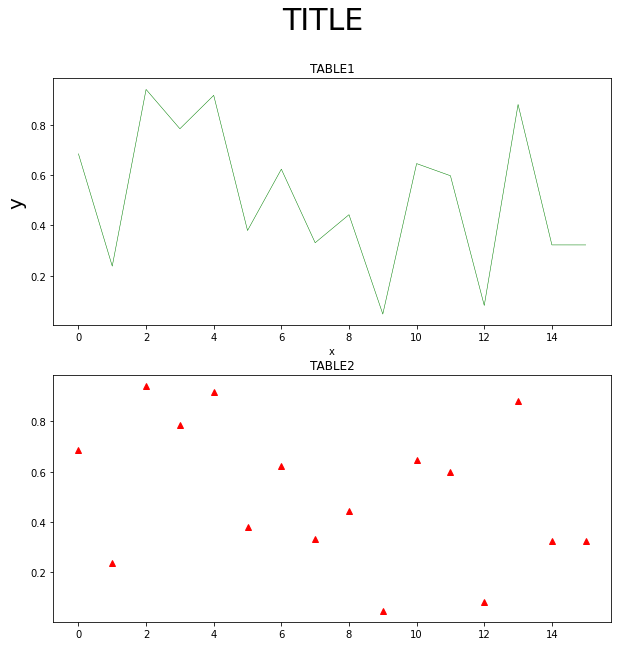

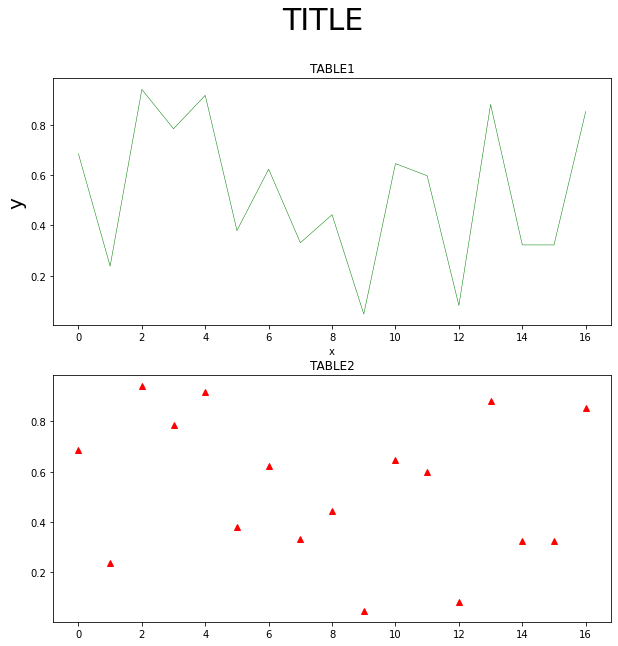

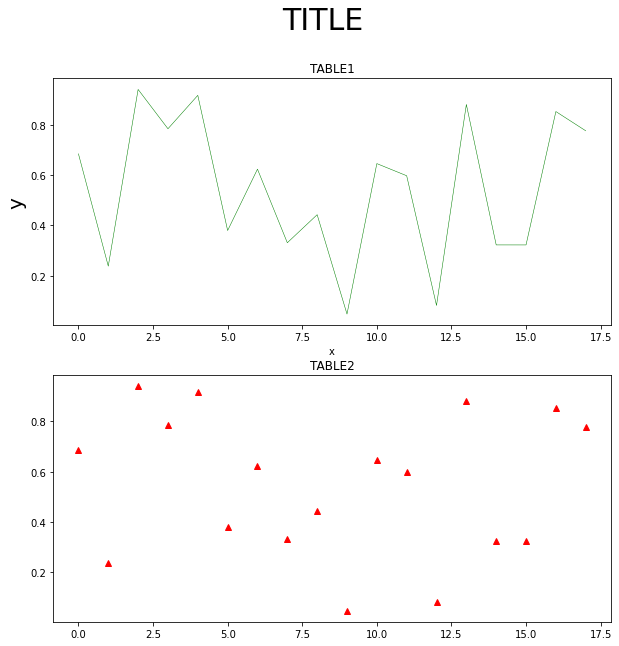

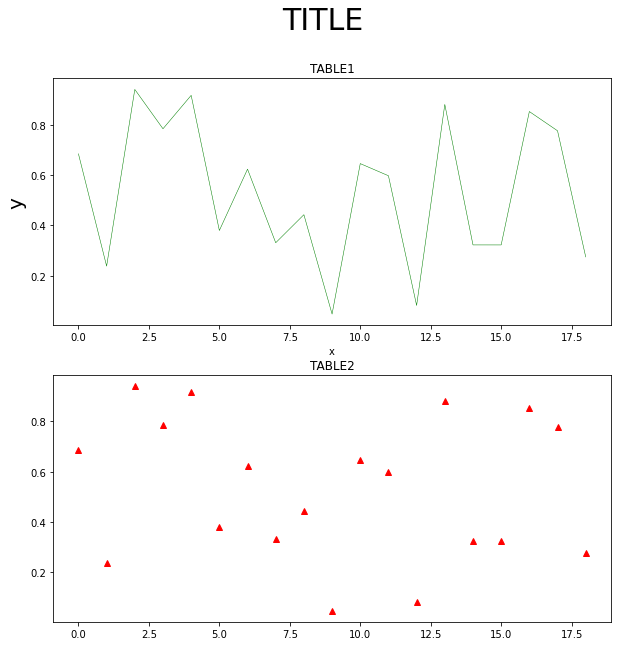

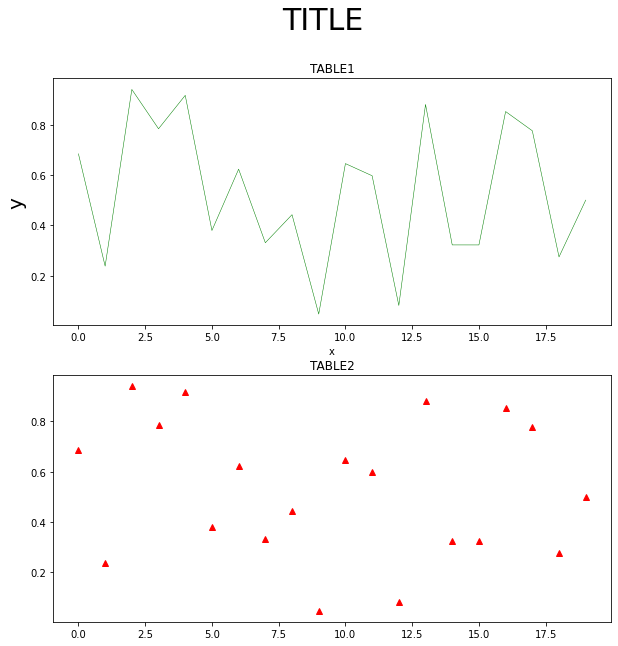

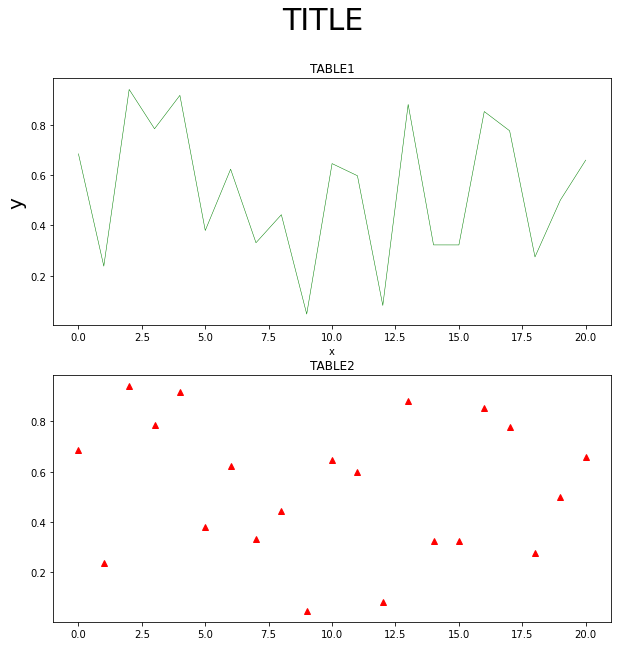

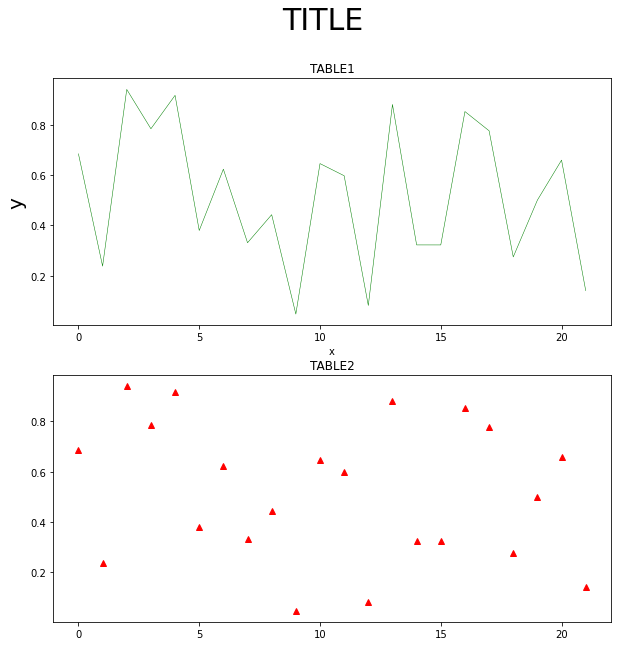

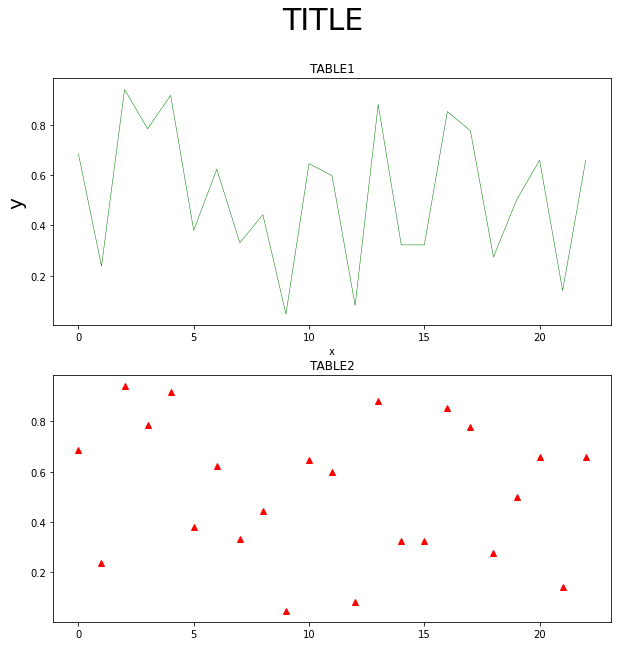

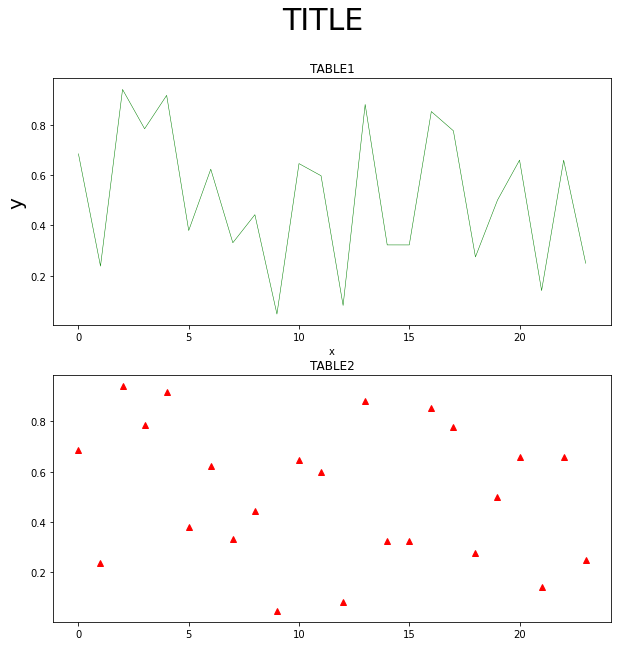

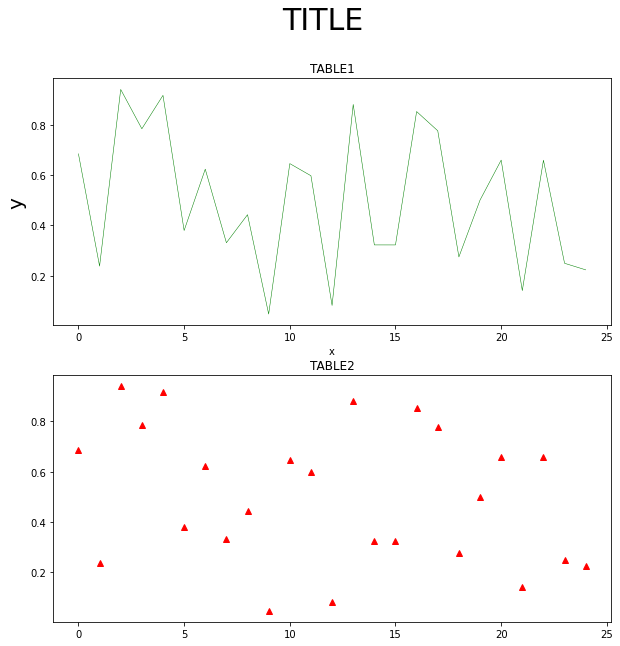

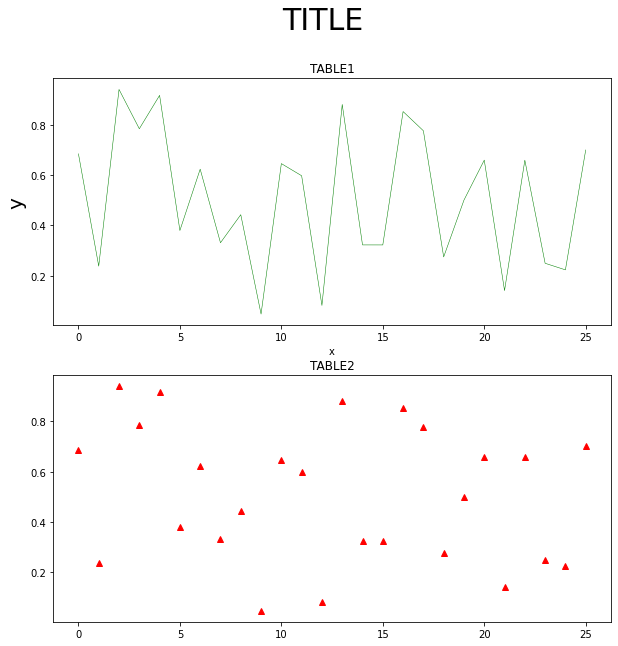

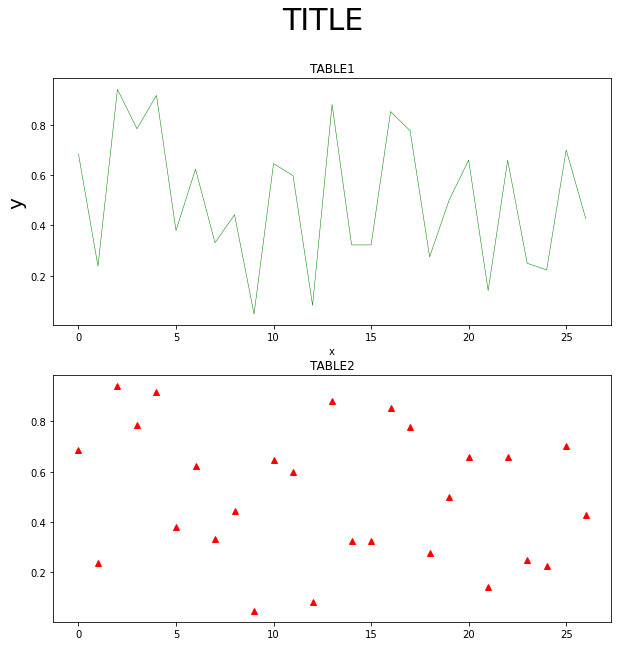

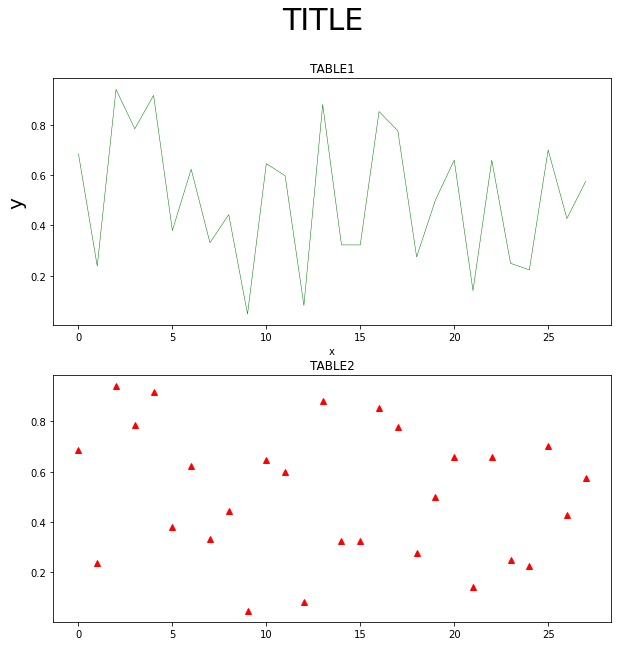

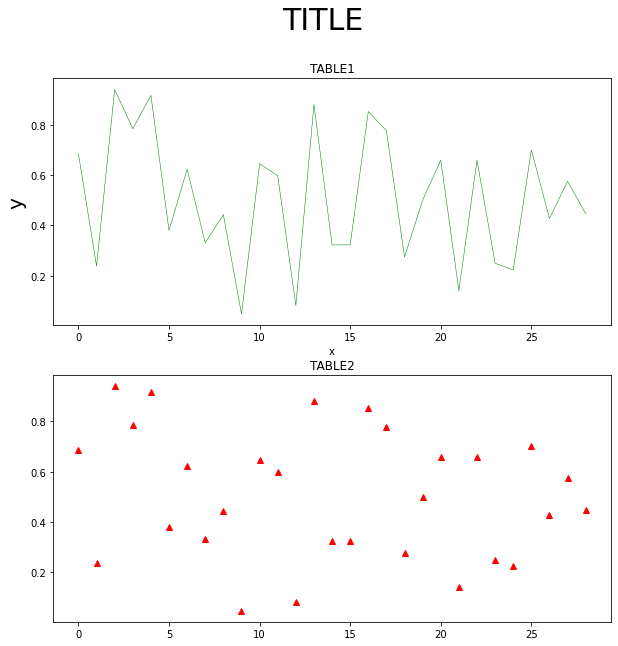

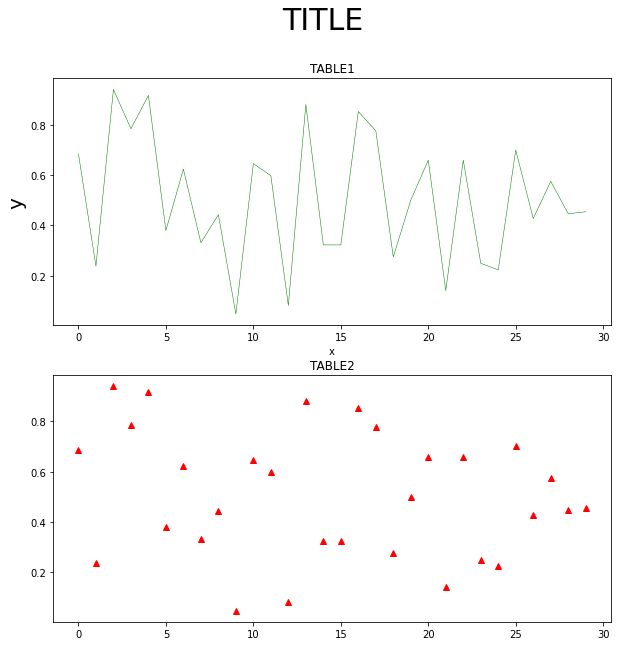

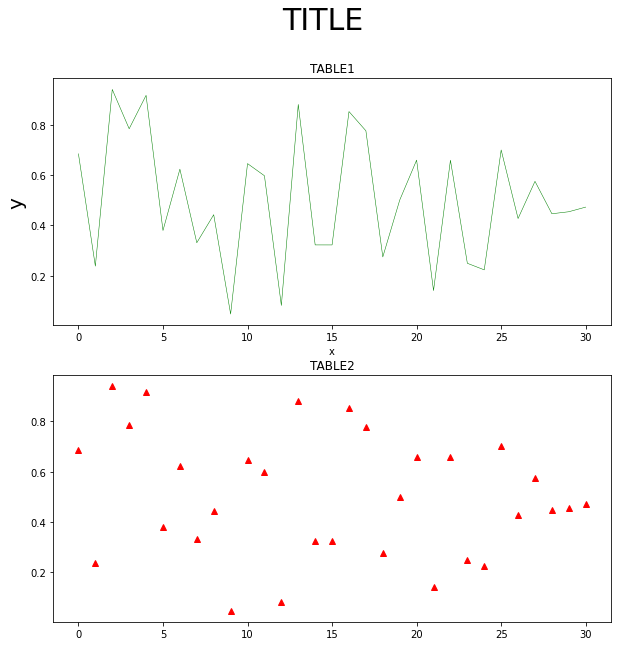

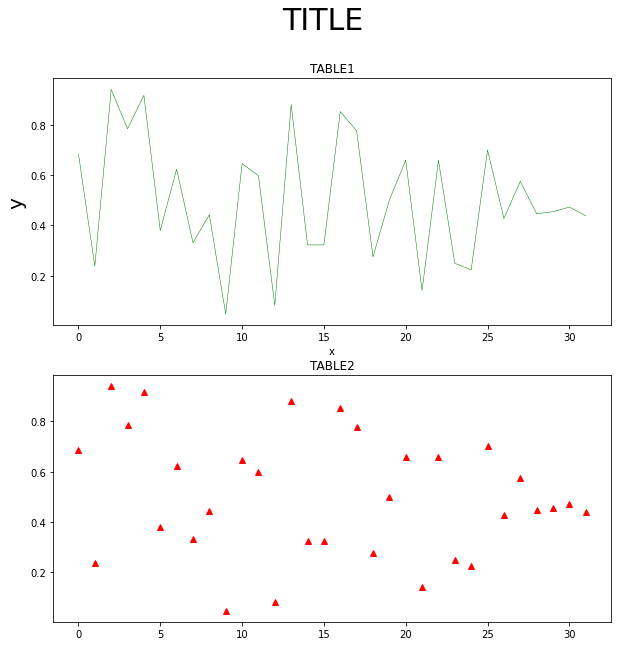

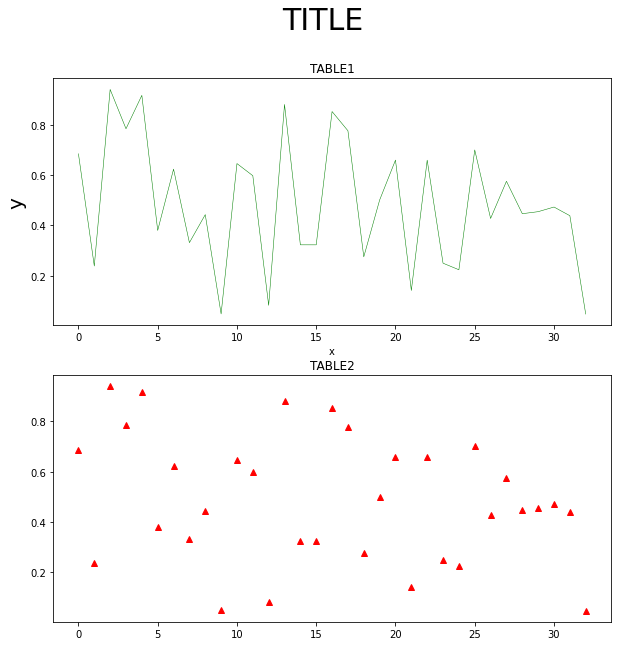

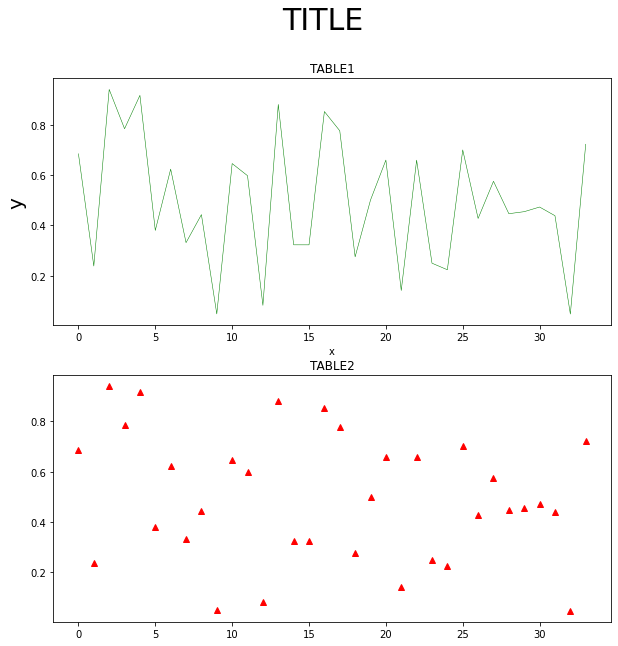

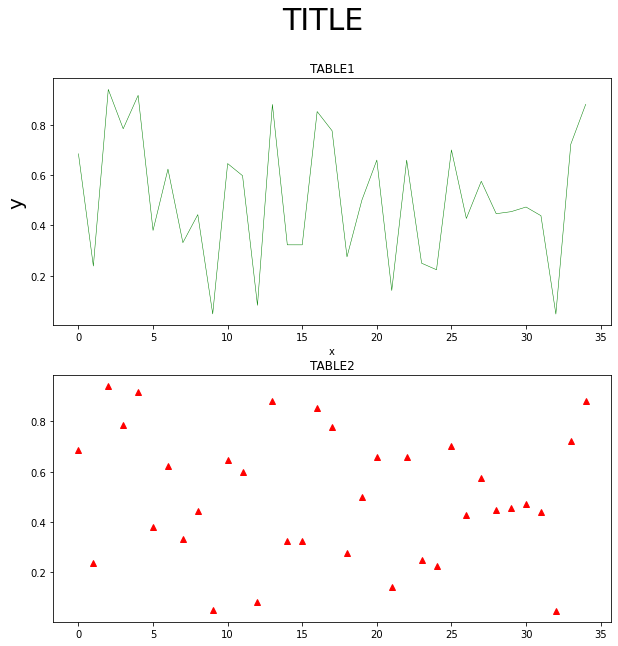

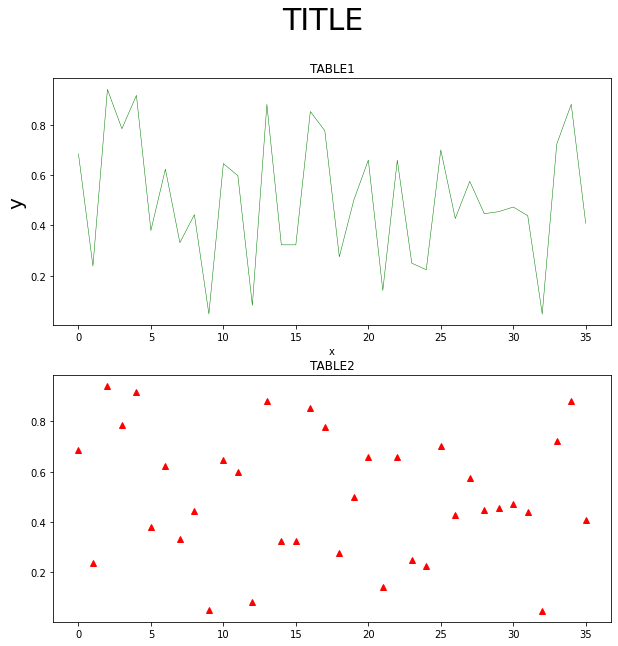

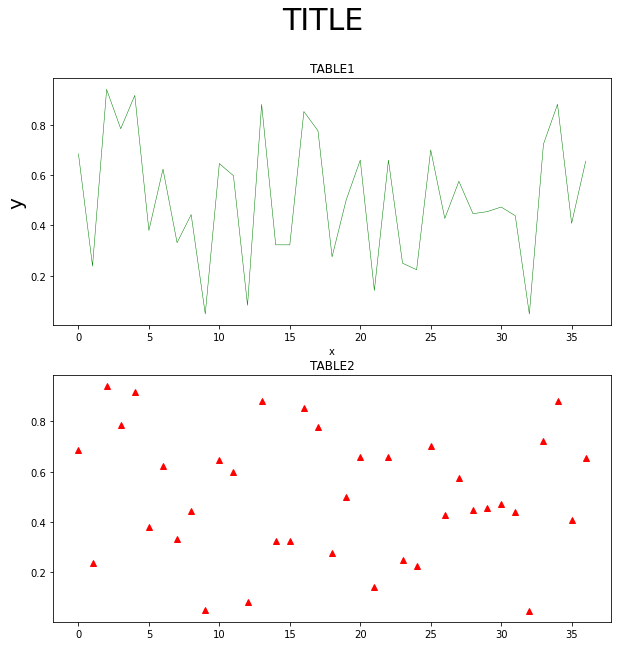

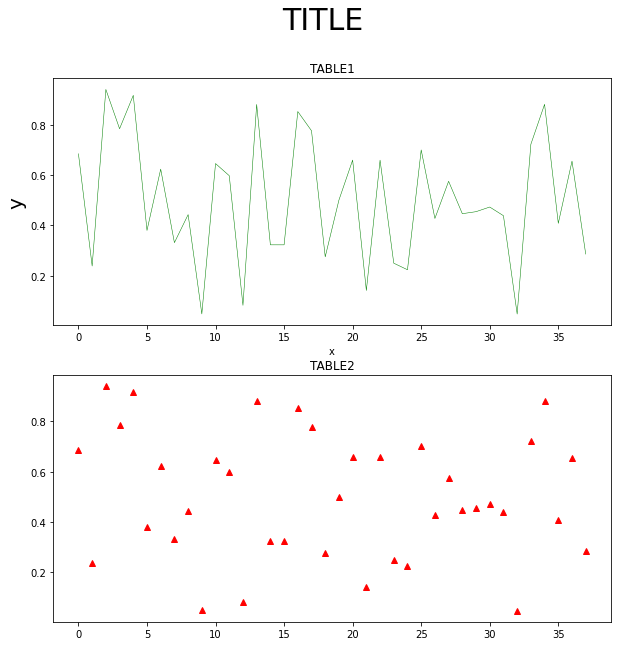

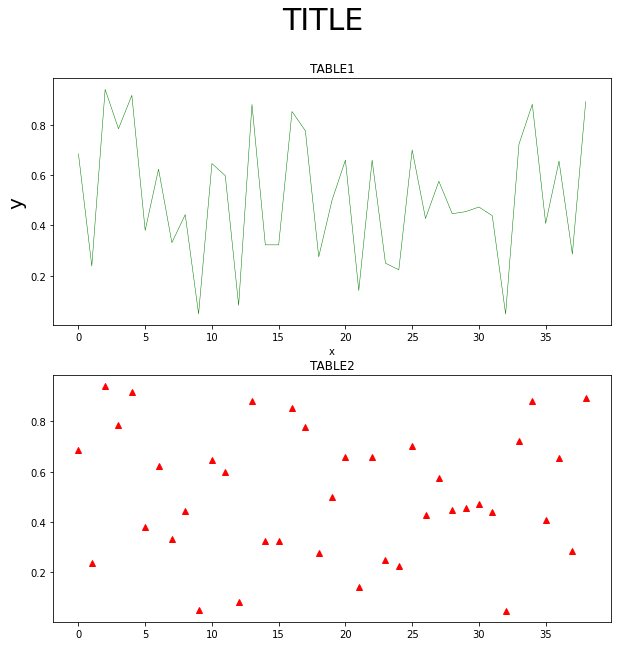

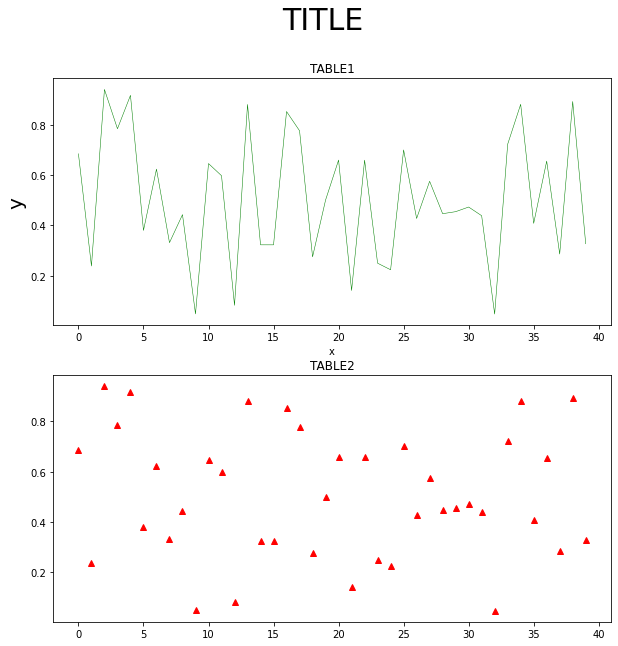

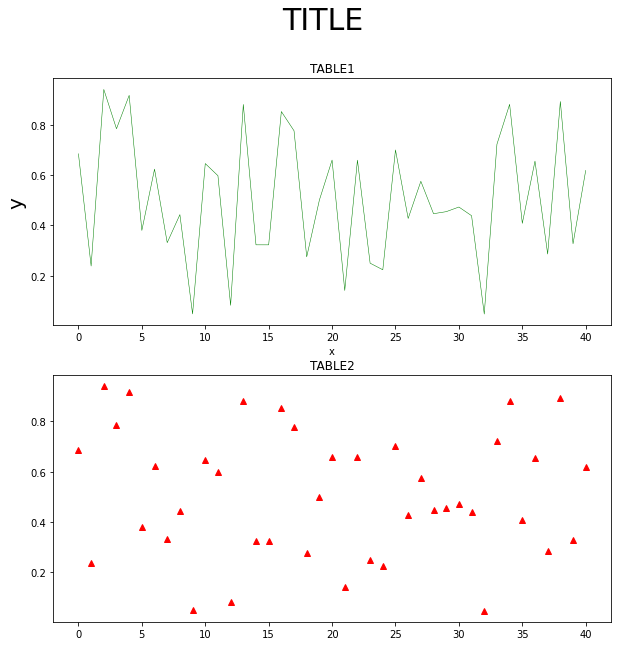

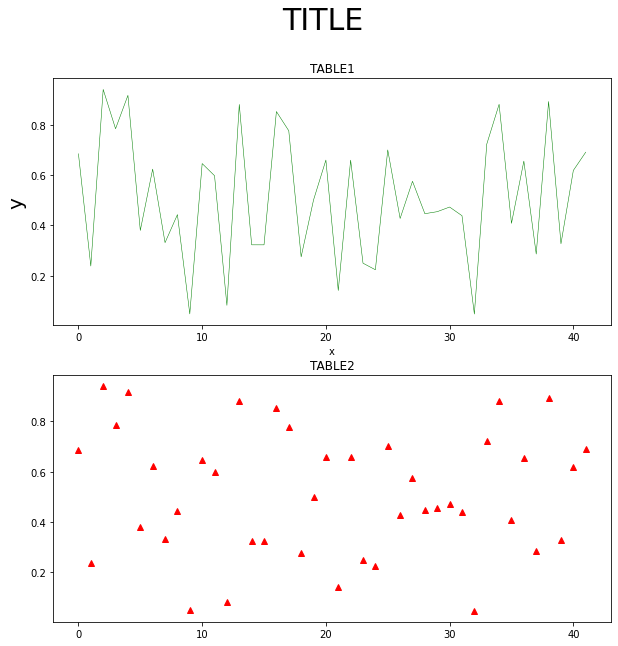

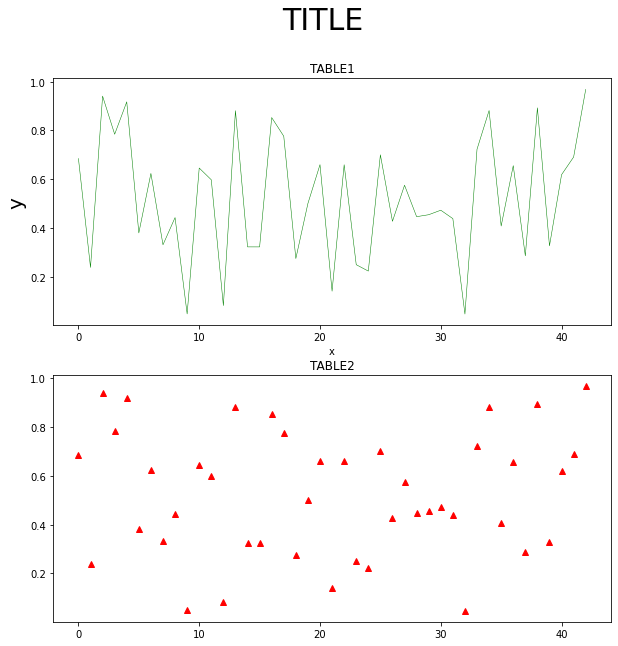

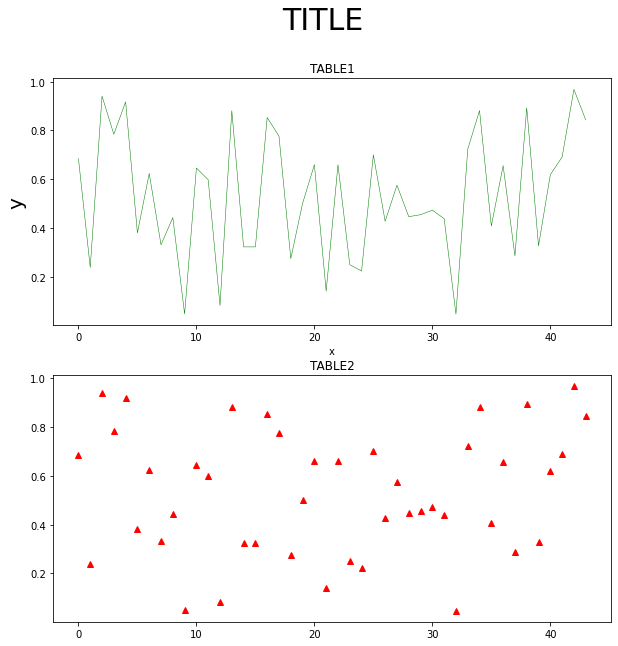

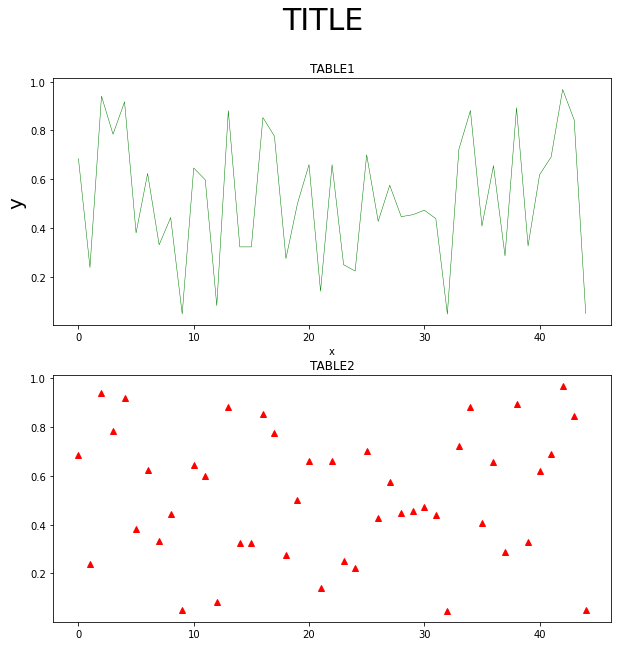

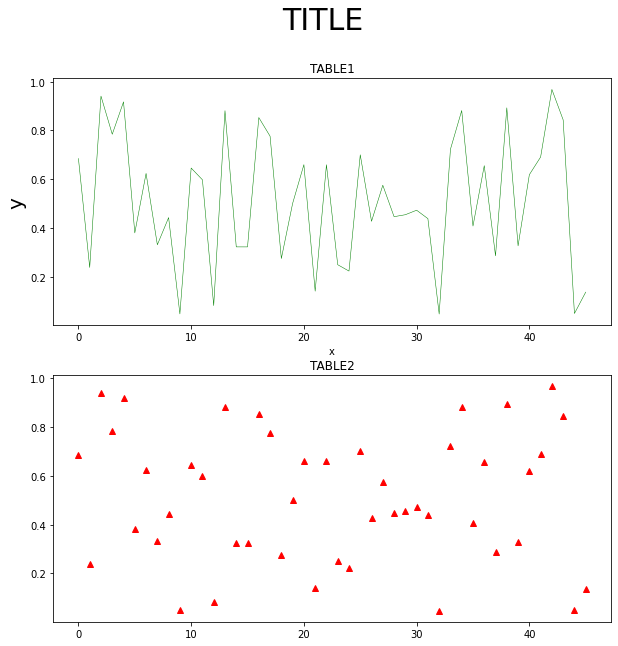

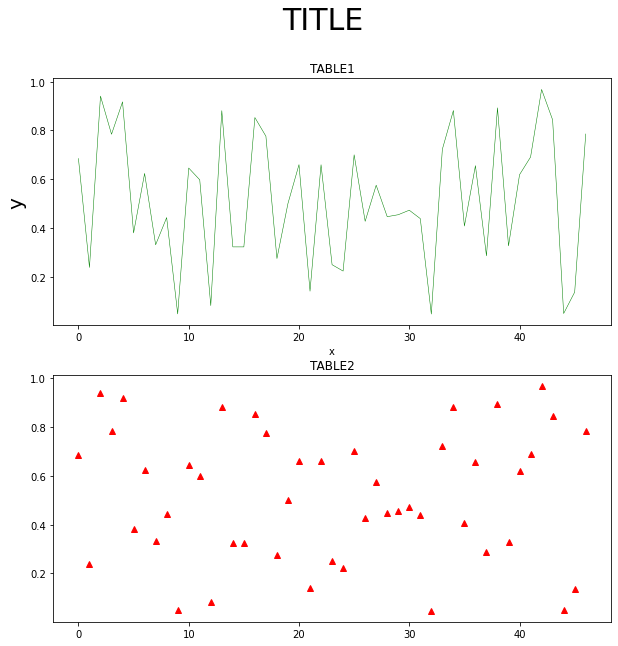

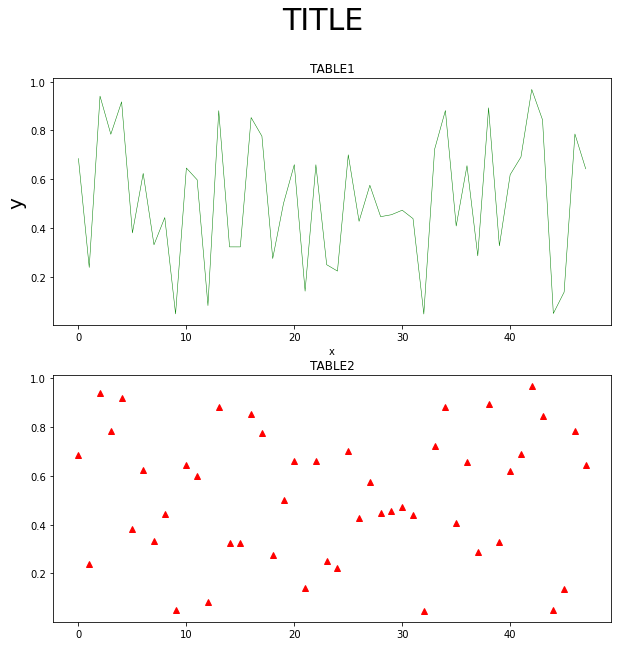

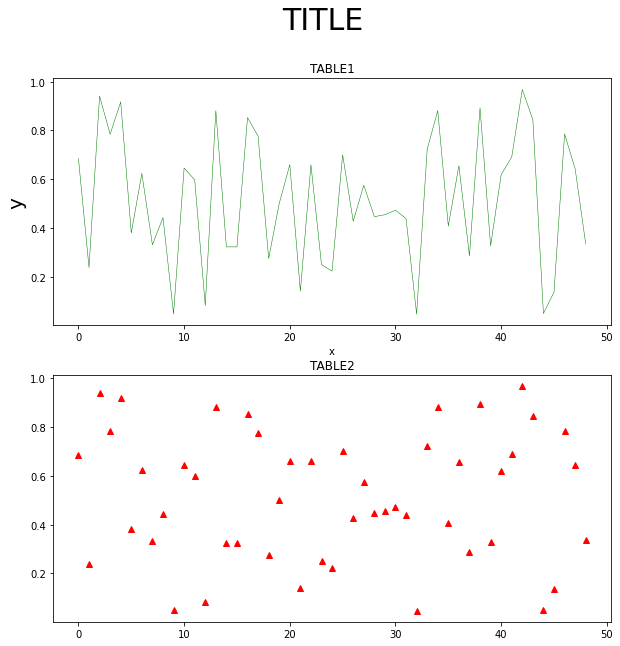

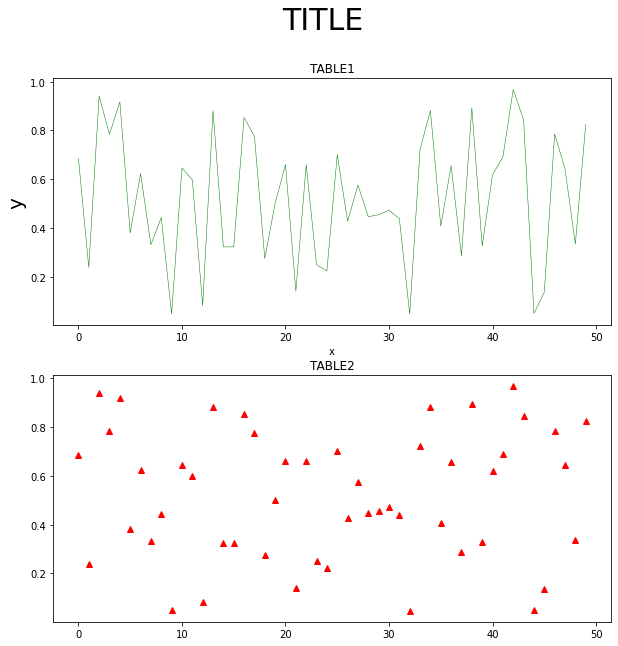

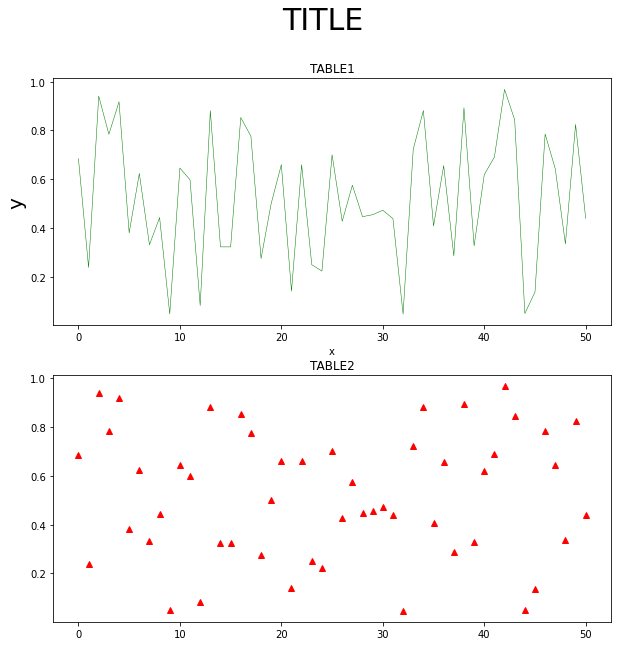

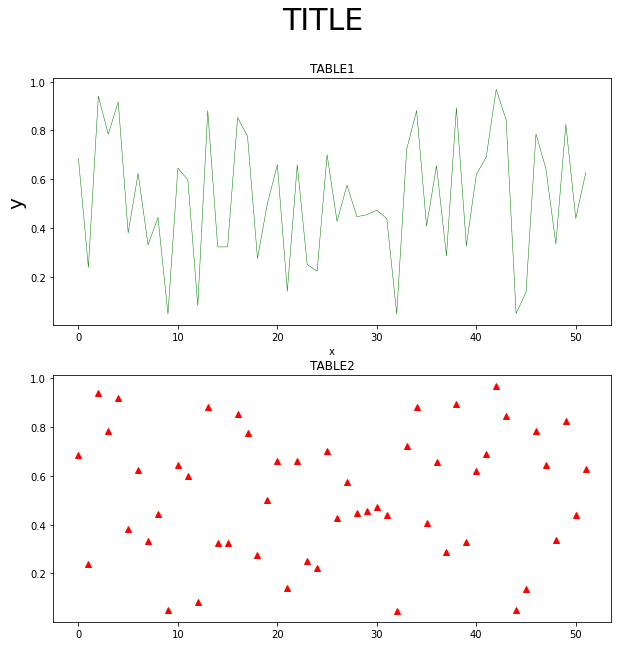

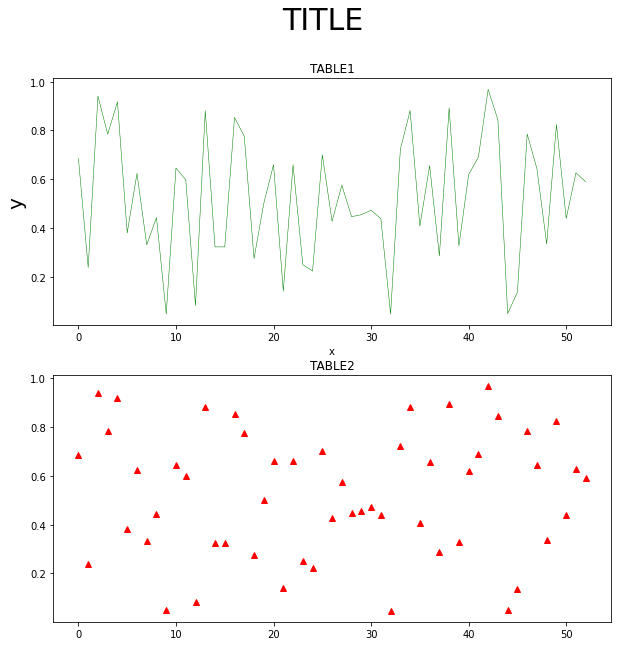

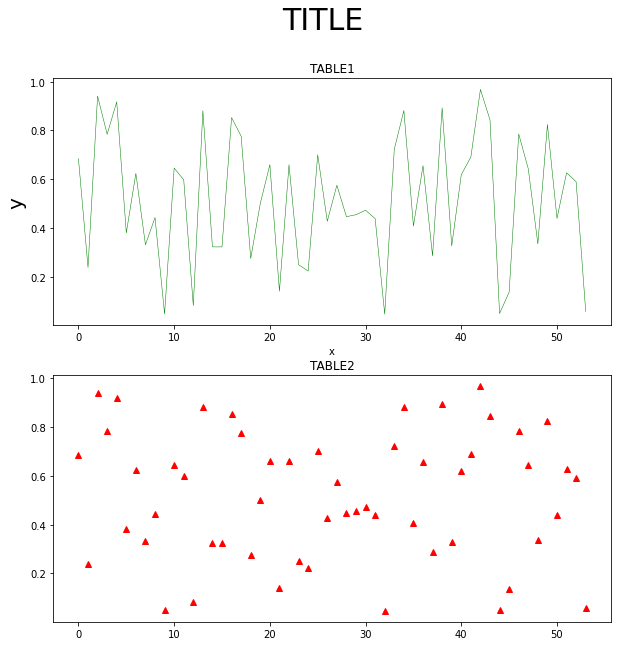

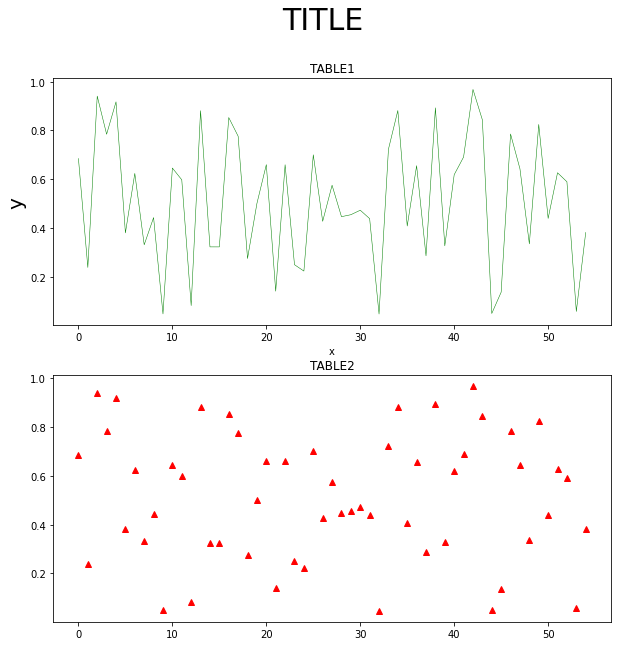

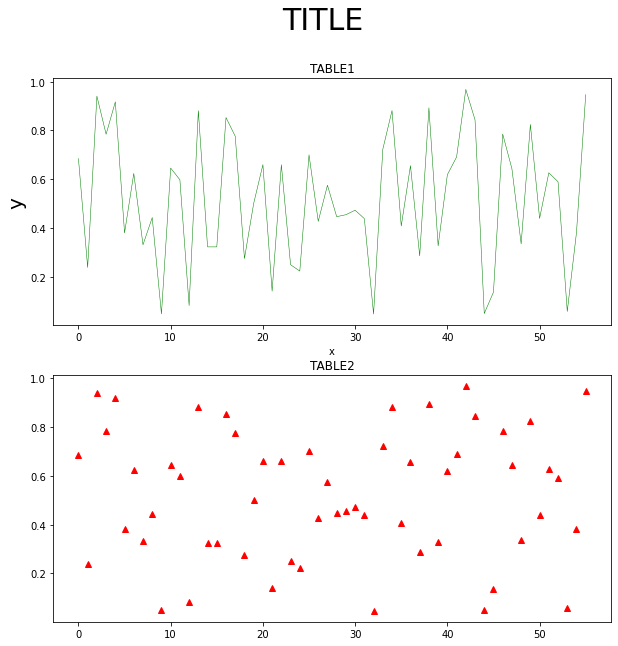

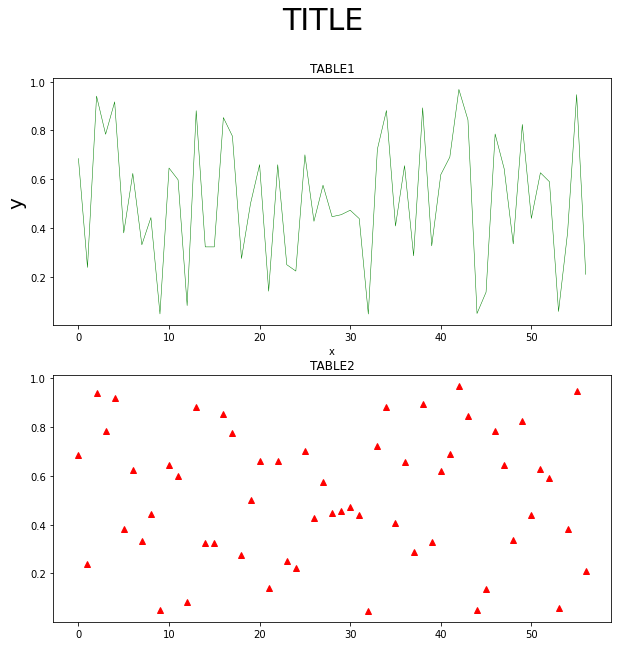

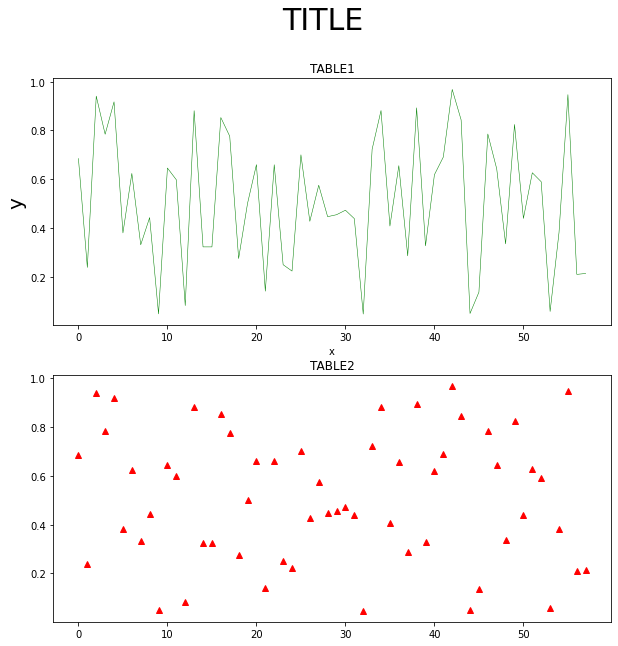

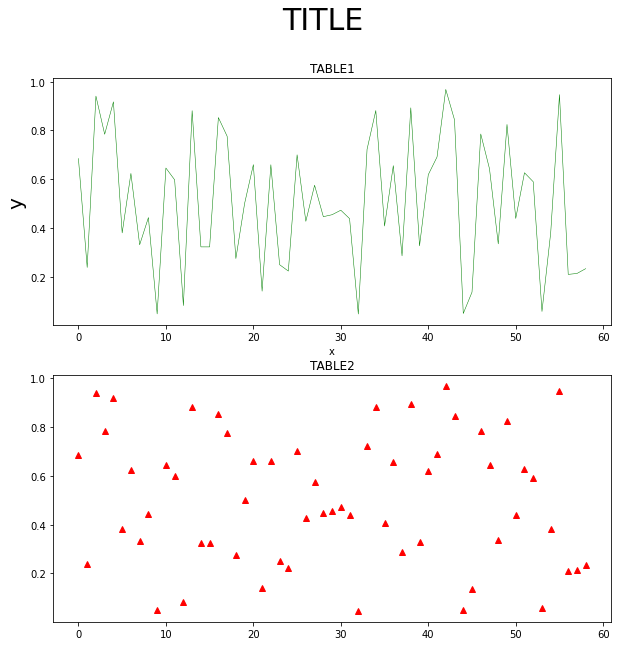

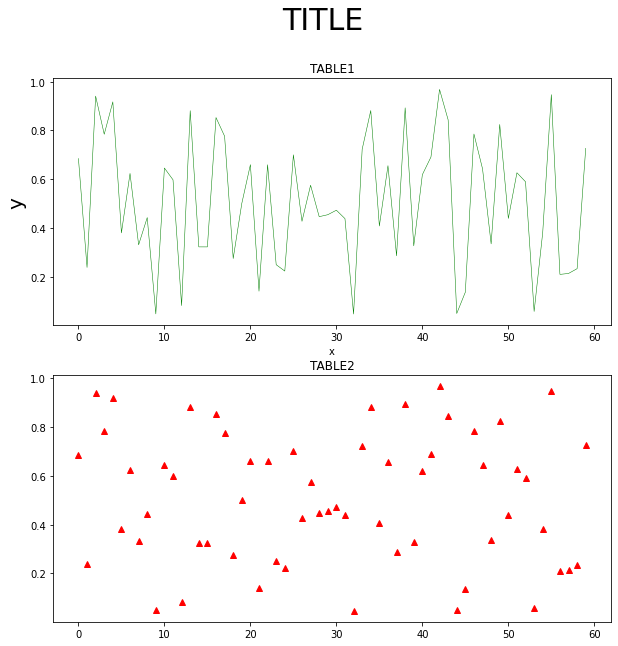

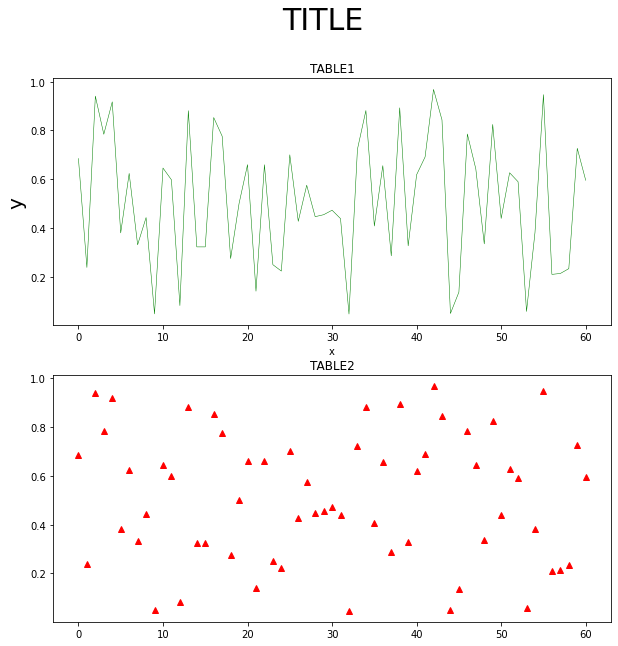

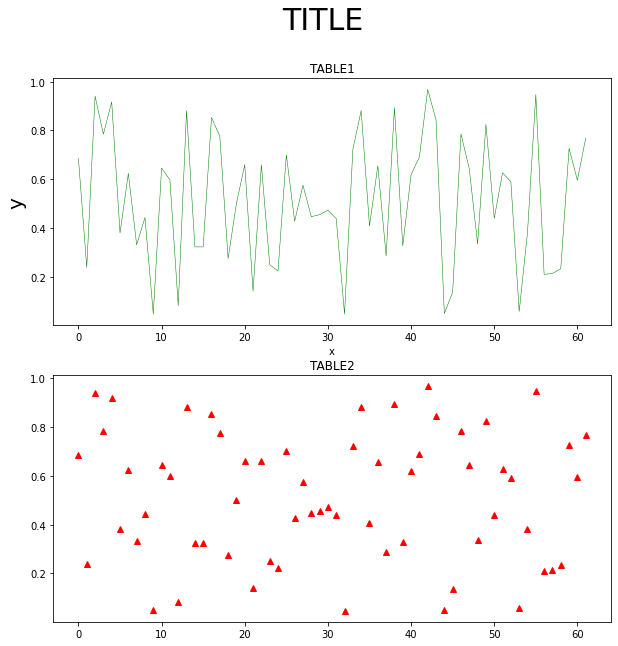

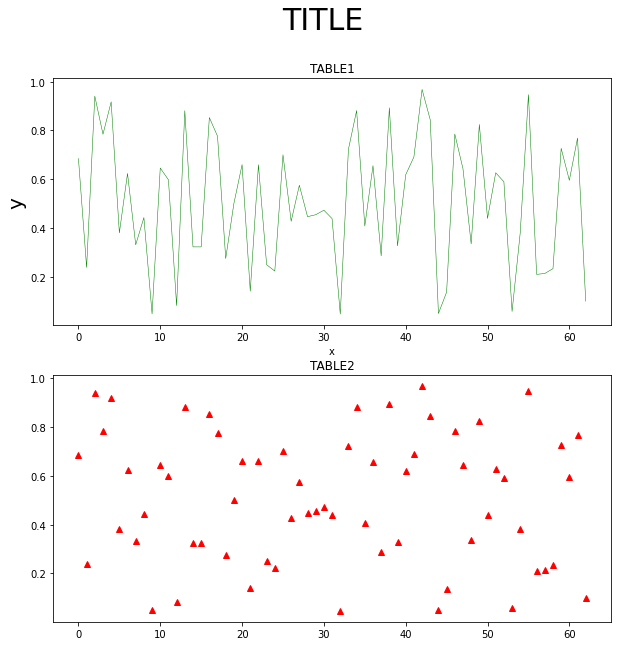

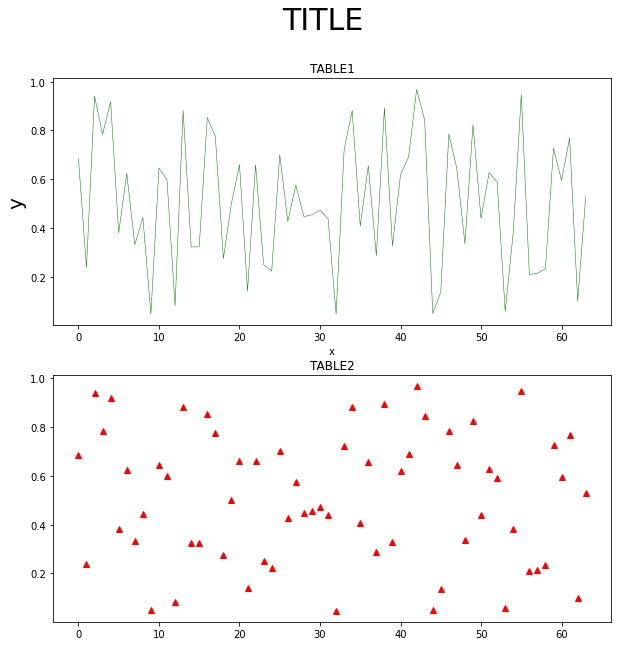

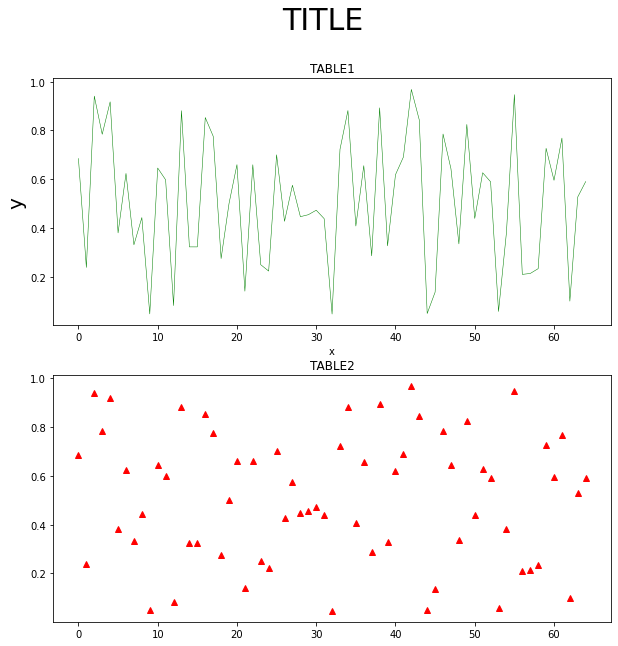

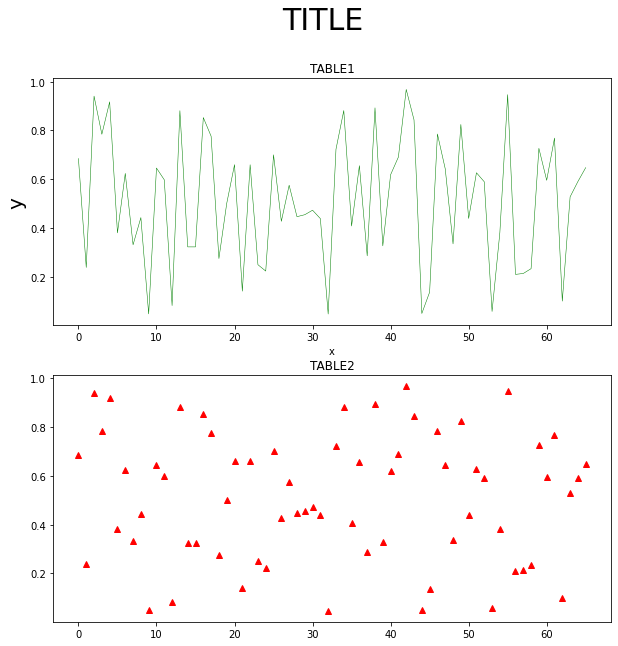

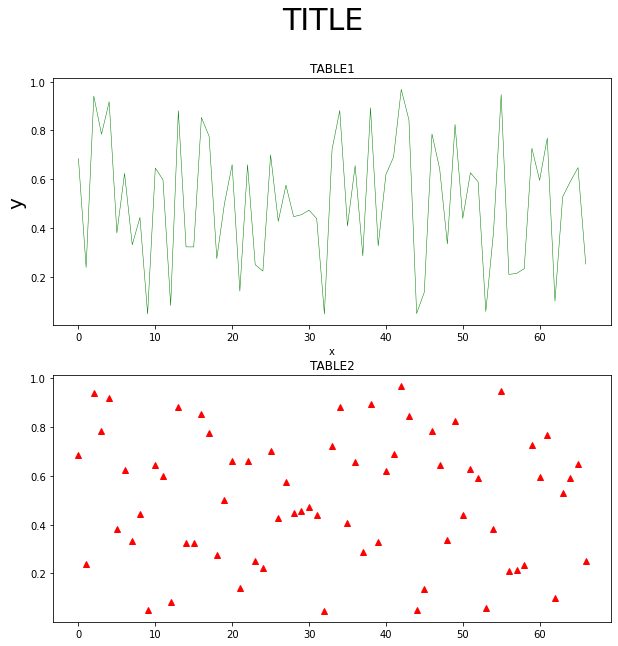

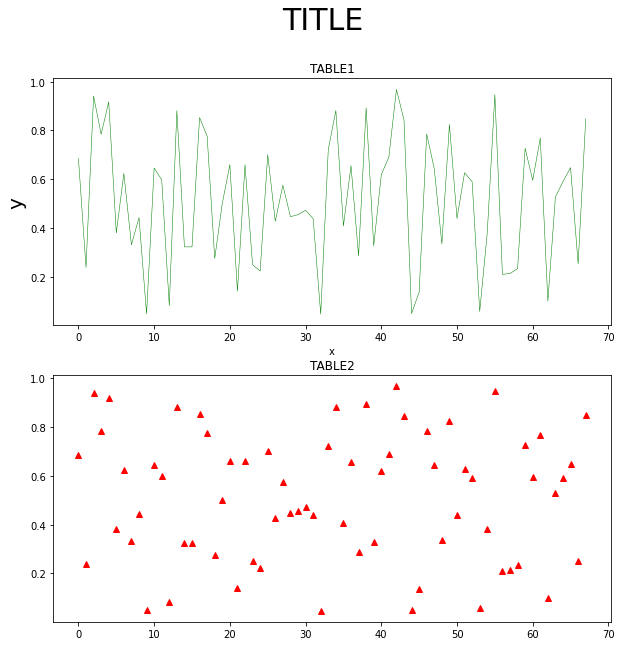

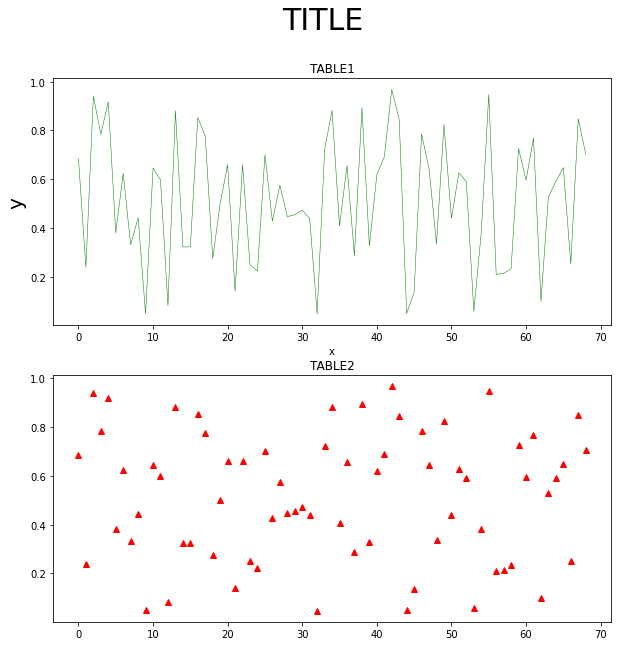

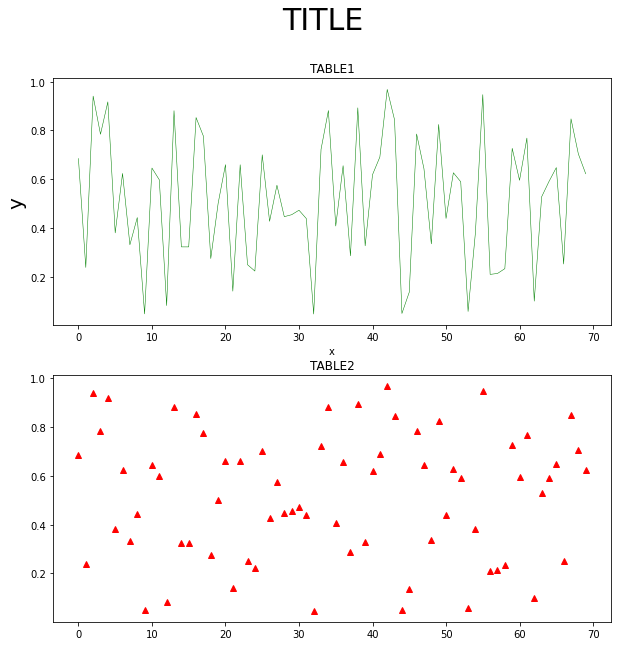

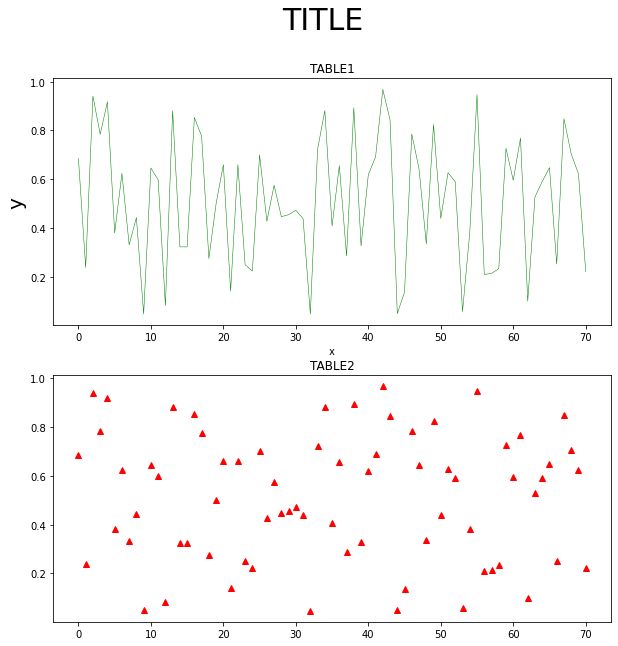

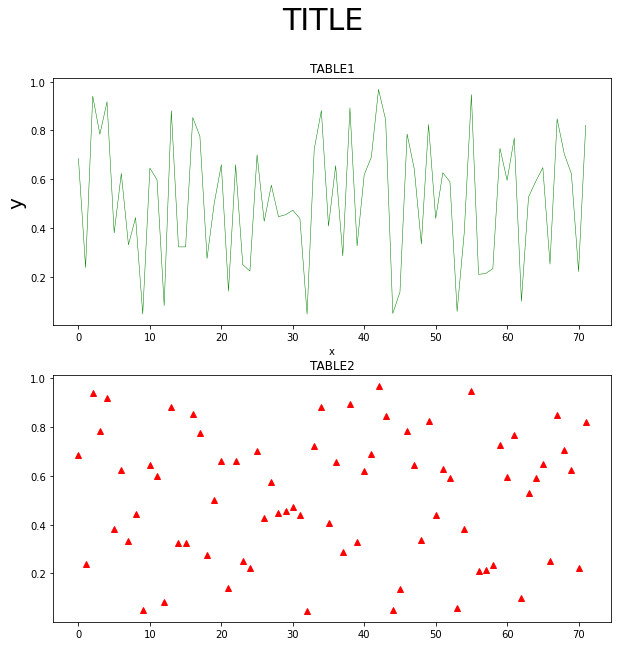

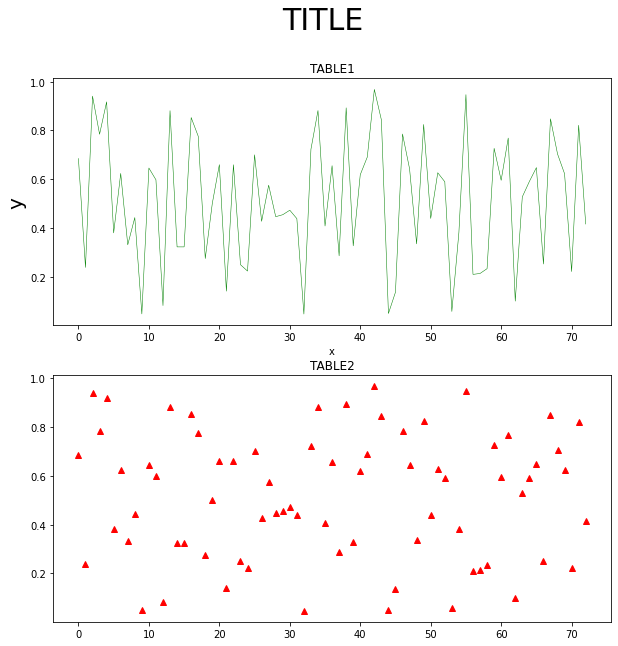

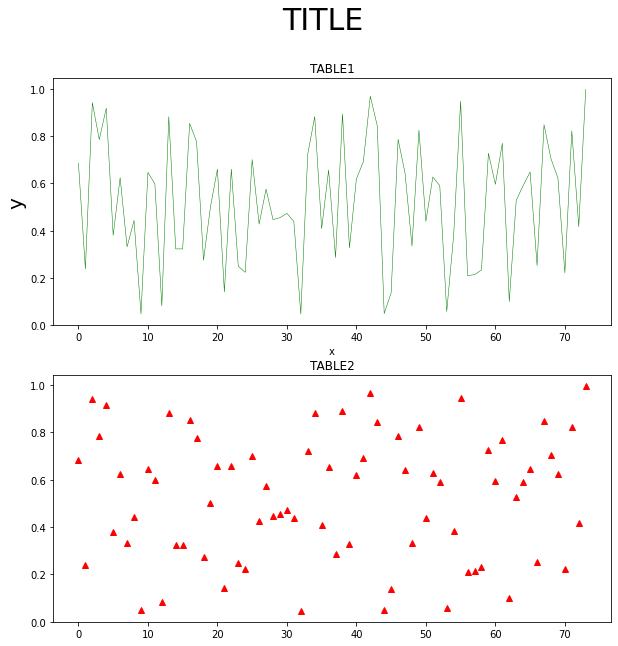

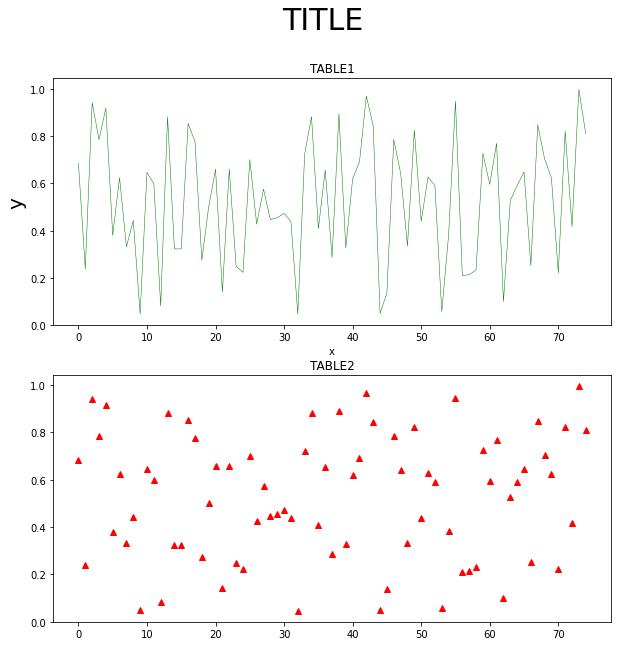

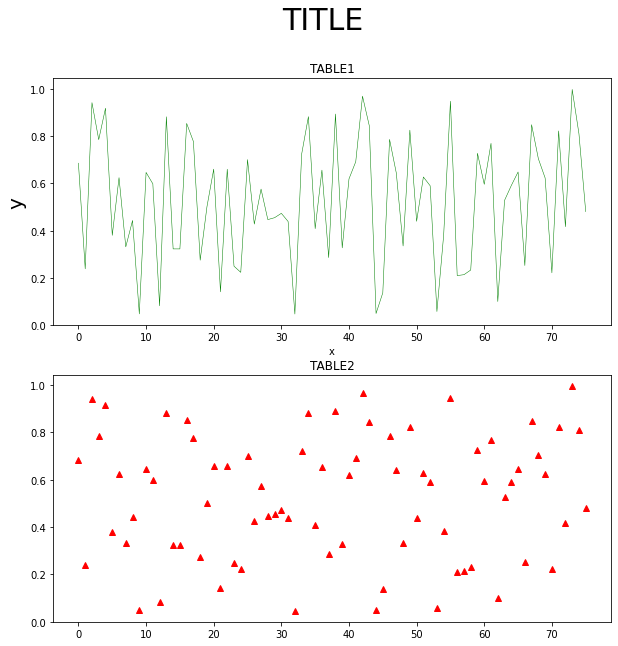

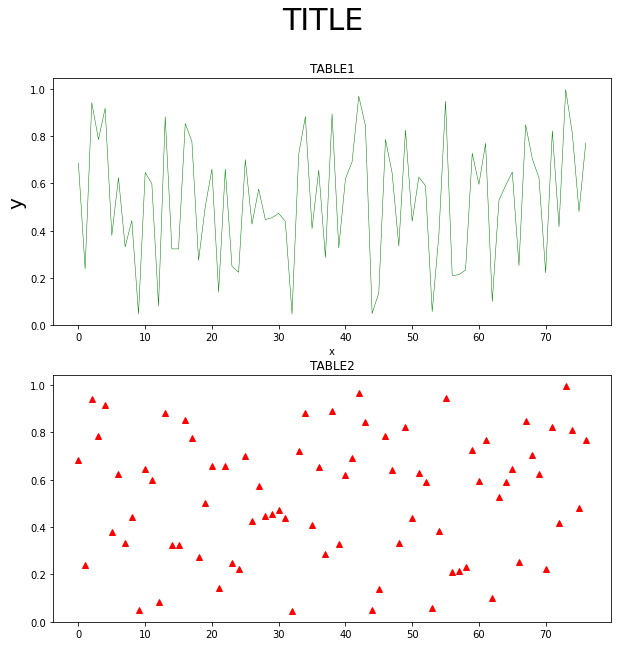

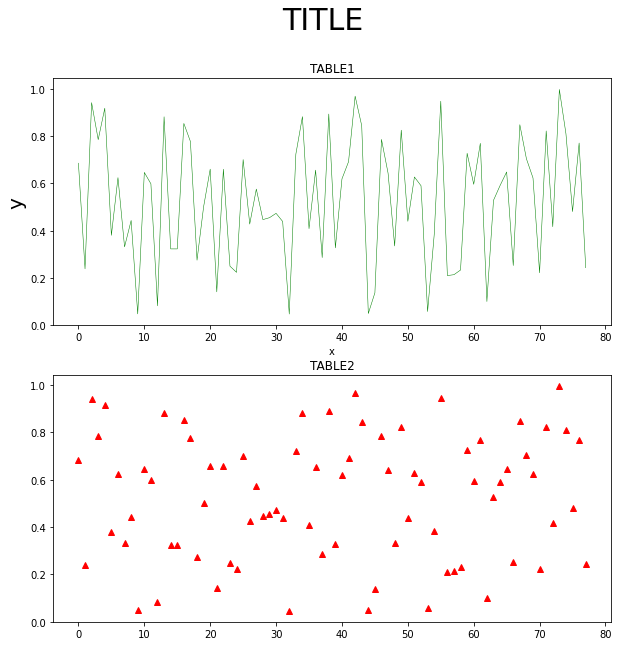

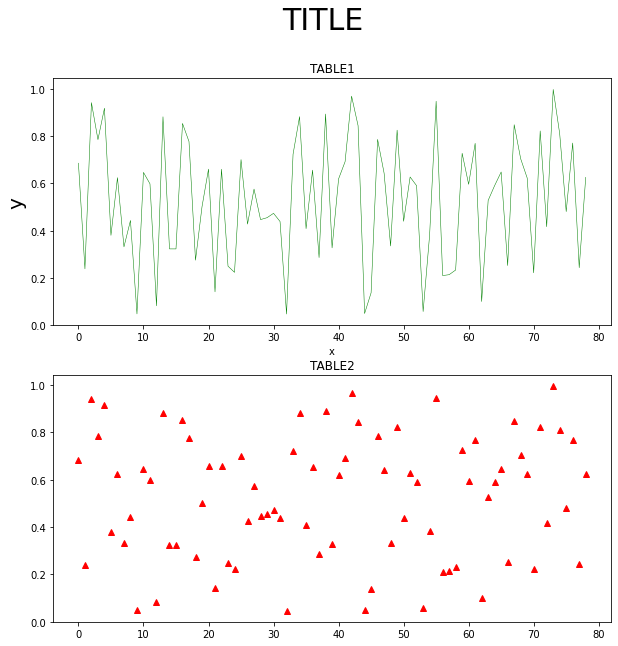

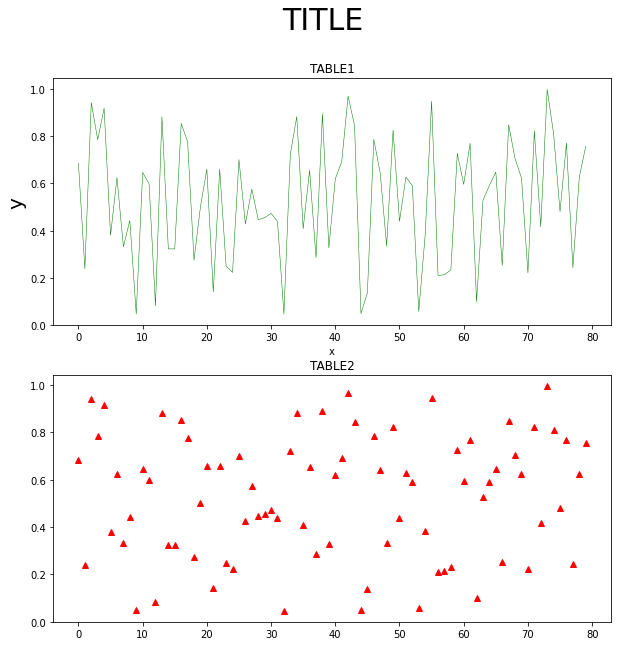

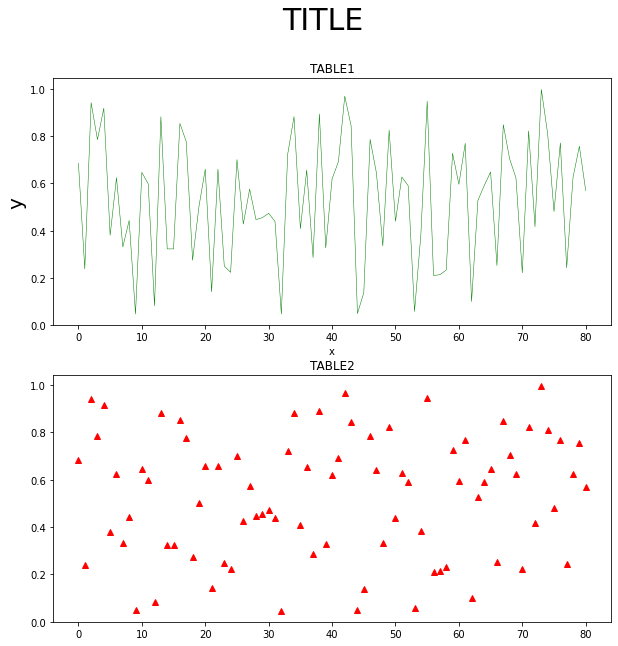

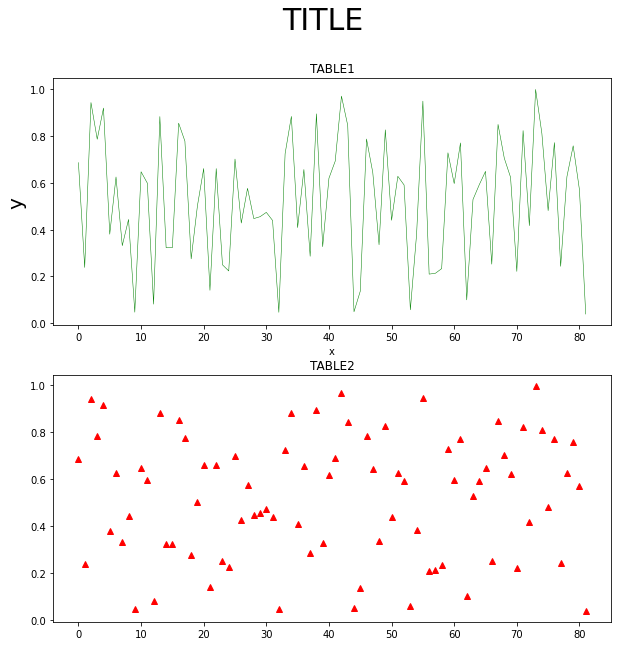

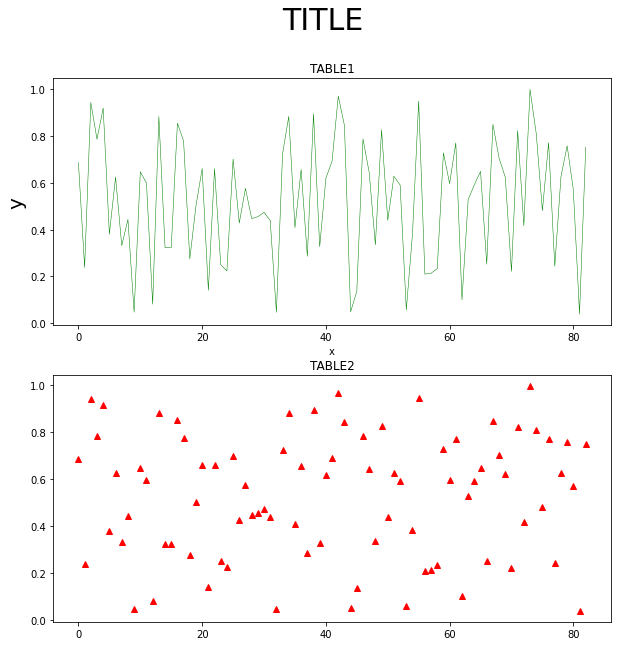

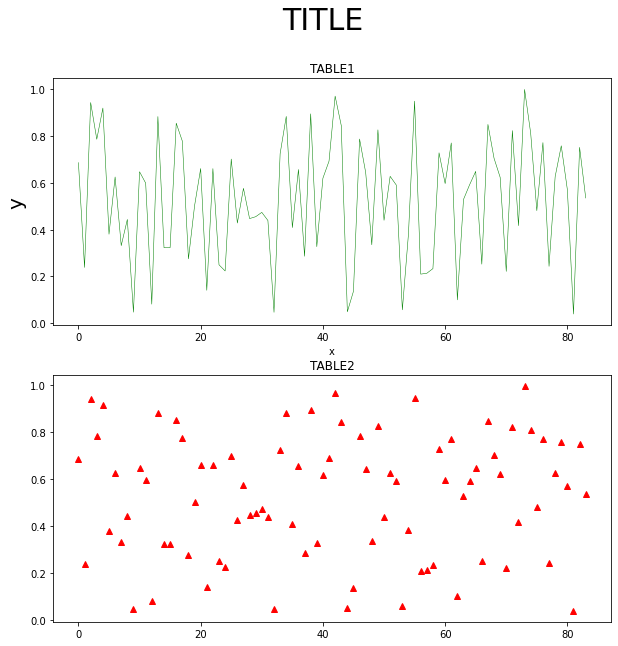

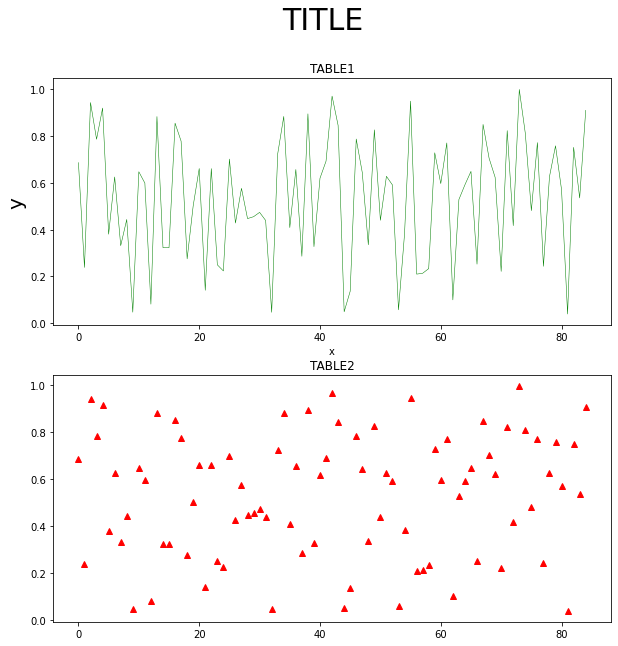

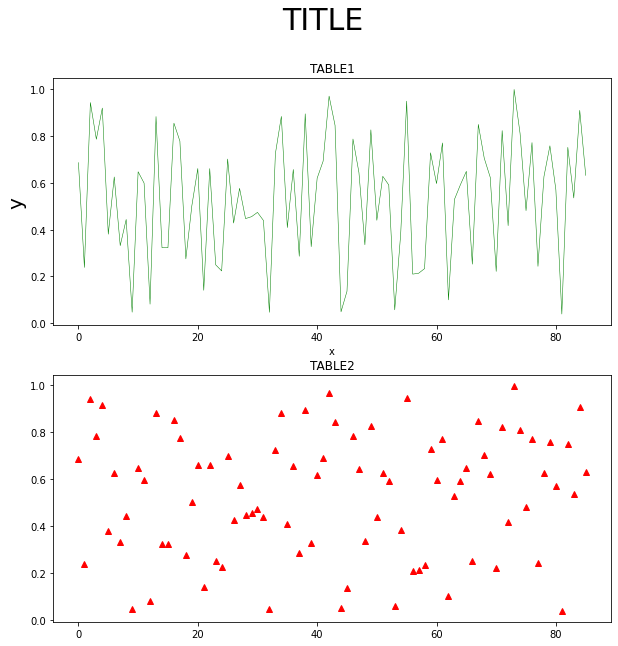

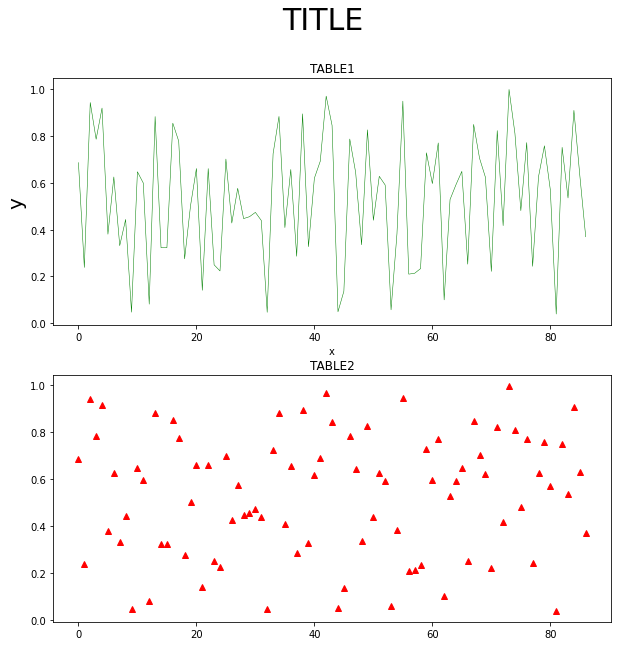

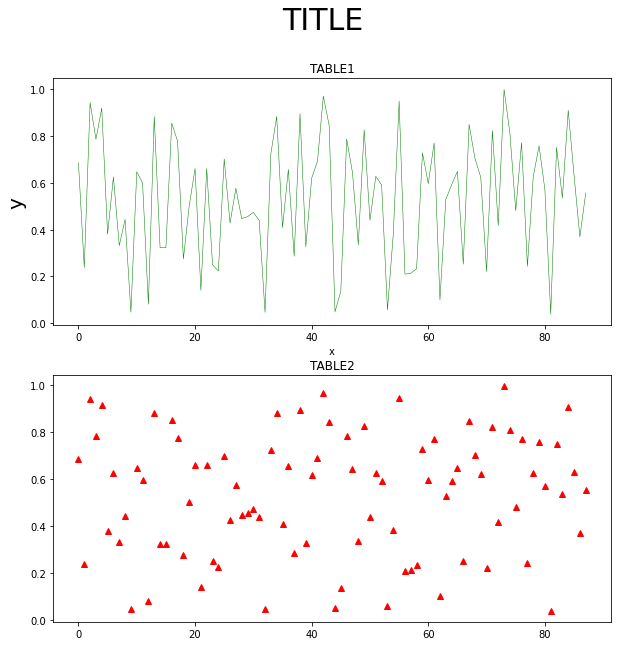

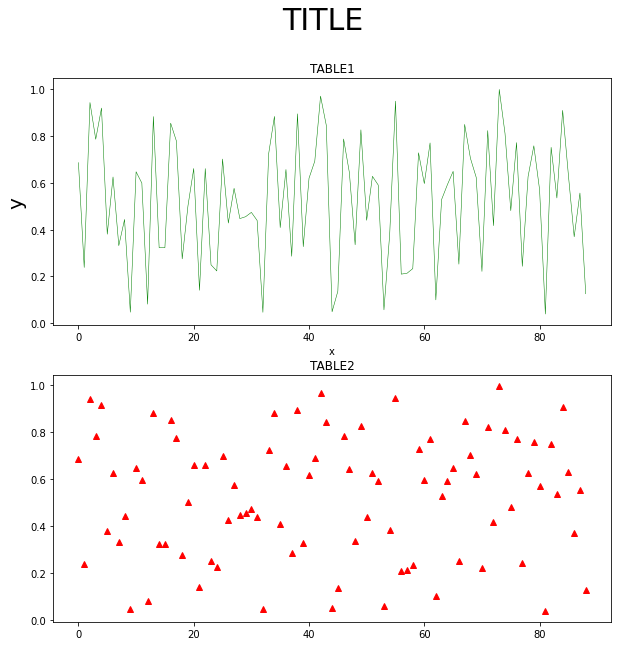

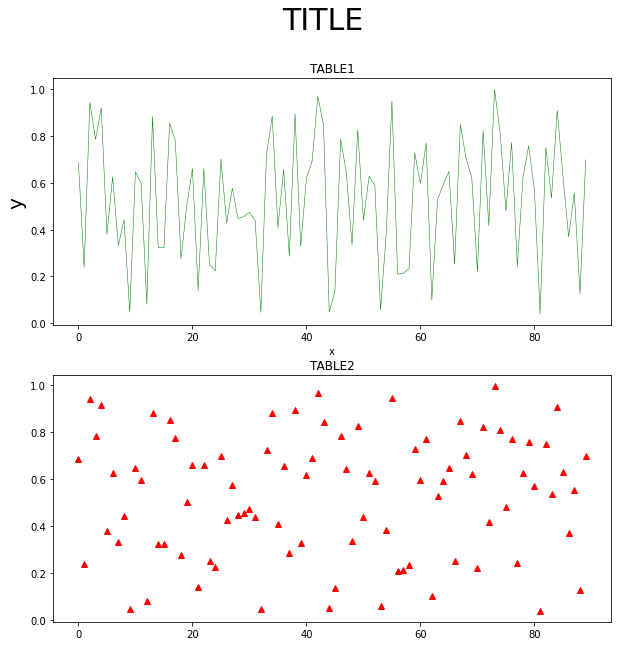

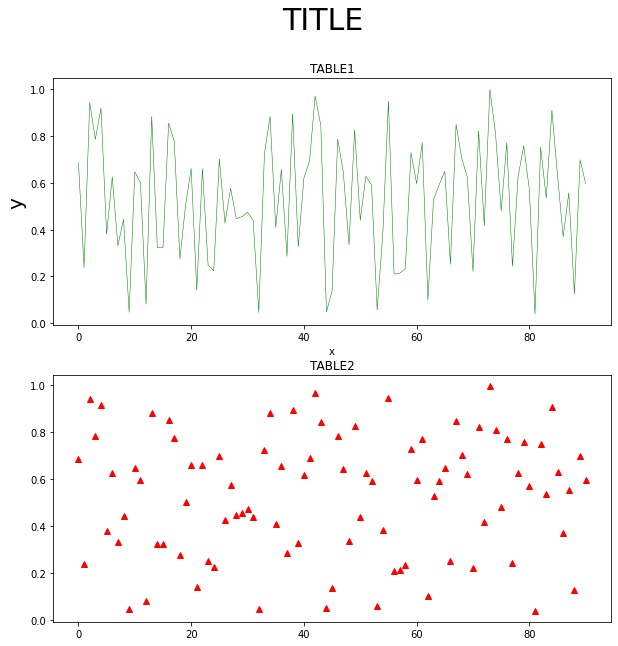

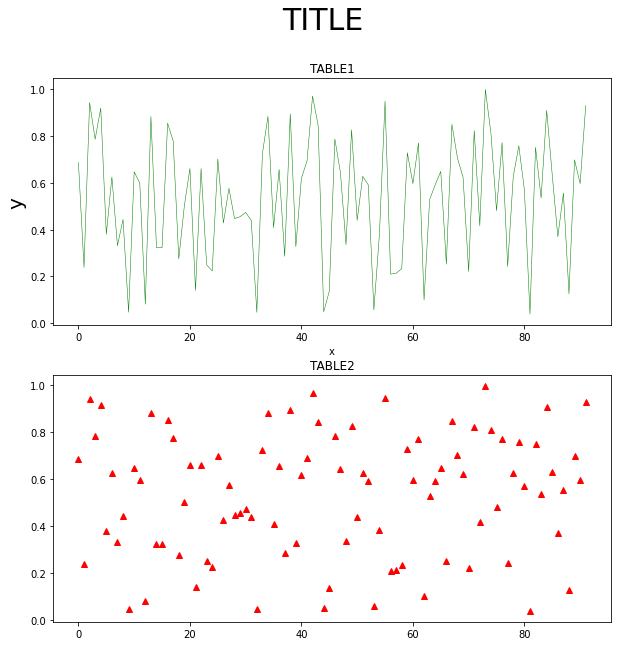

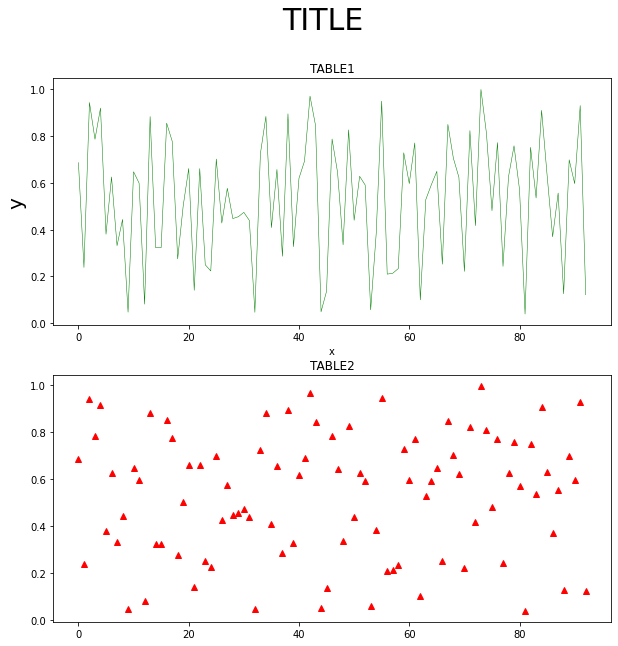

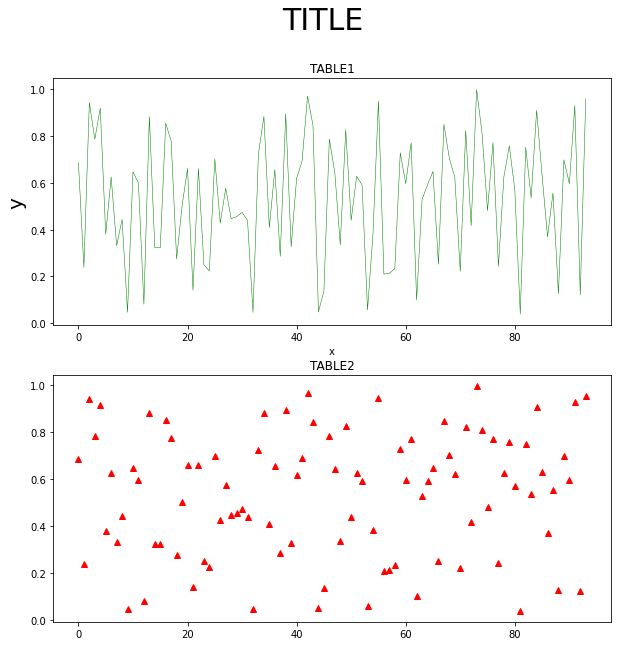

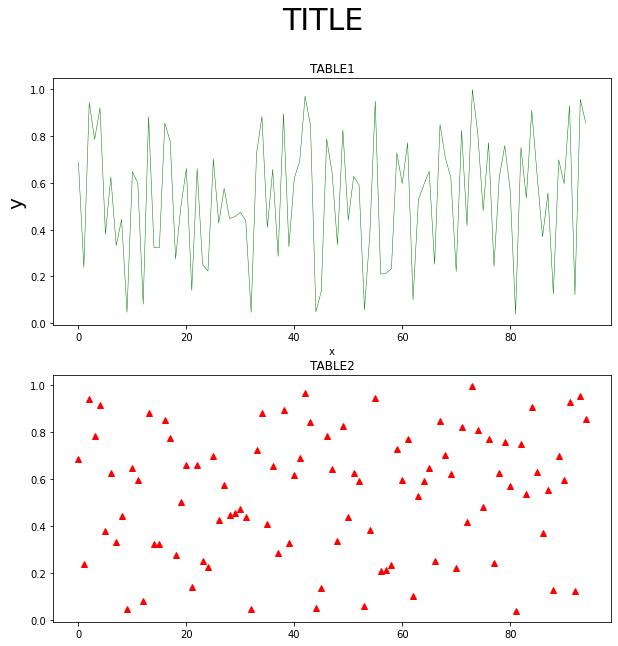

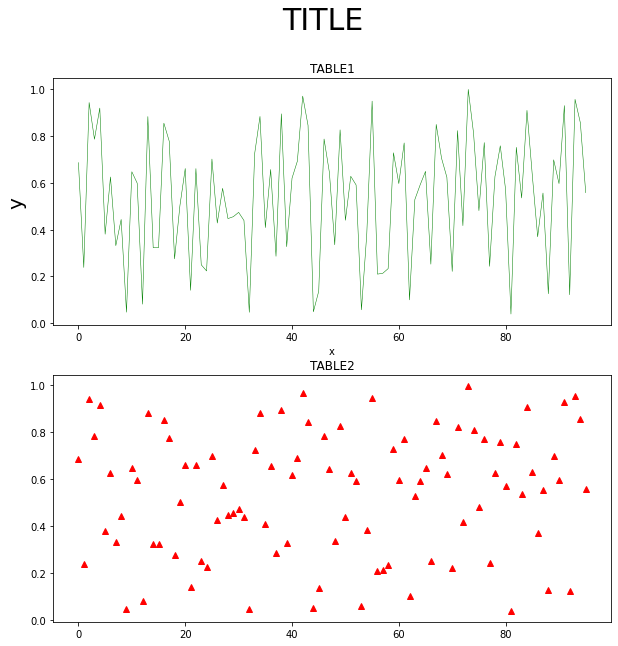

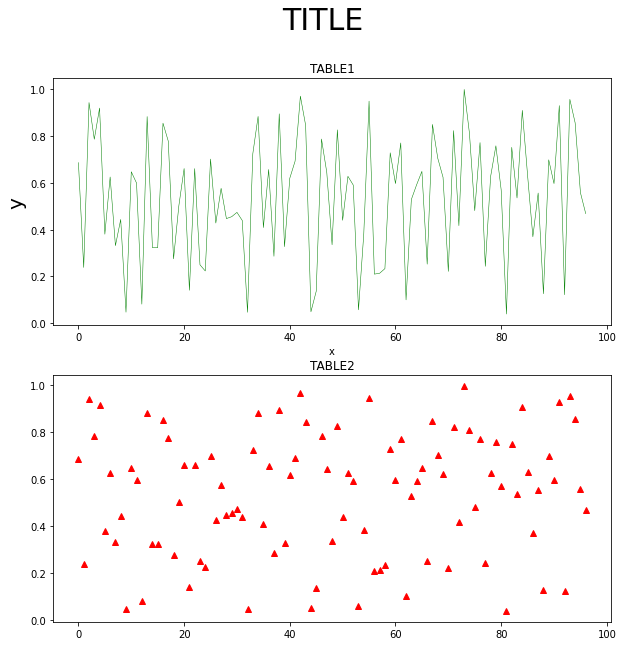

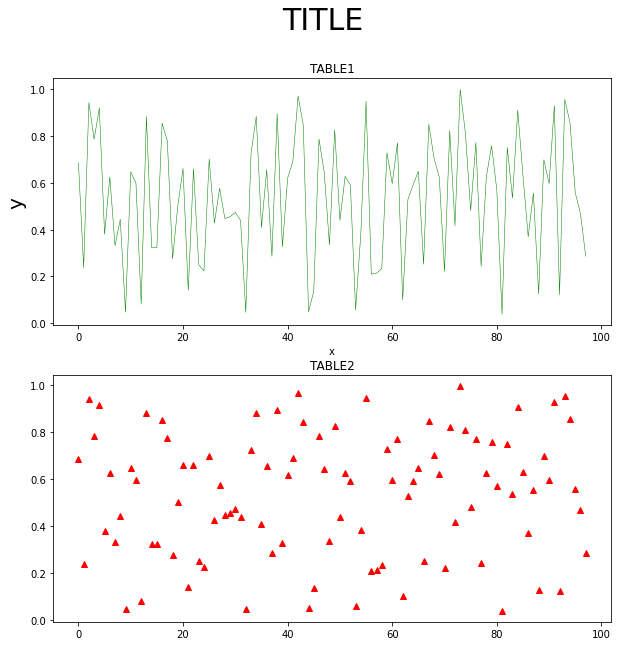

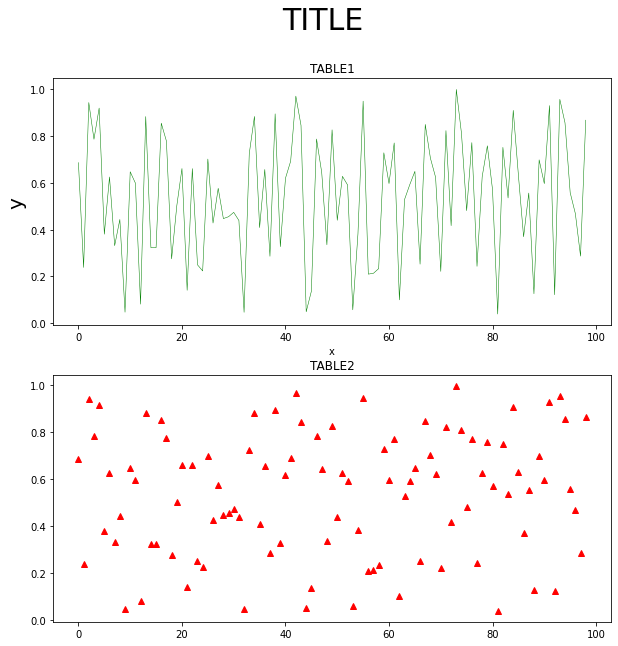

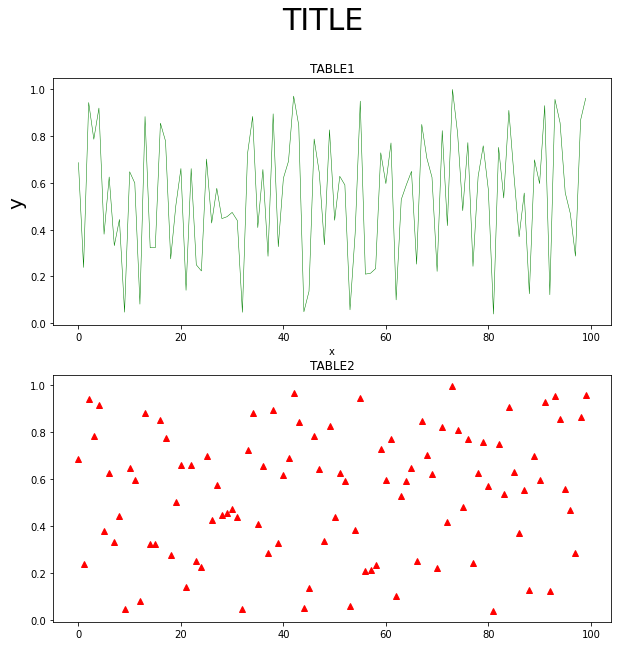

In [45]:
import matplotlib.pyplot as plt
import numpy as np

ax=[]  
ay=[]
bx=[]   
by=[]
num=0  
plt.ion()    
# plt.rcParams['savefig.dpi'] = 200 
# plt.rcParams['figure.dpi'] = 200 
plt.rcParams['figure.figsize'] = (10, 10)        
plt.rcParams['font.sans-serif']=['SimHei']   
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['lines.linewidth'] = 0.5   
while num<100:
    plt.clf()    
    plt.suptitle("TITLE",fontsize=30)            
    g1=np.random.random()  
    
    ax.append(num)      
    ay.append(g1)       
    agraphic=plt.subplot(2,1,1)
    agraphic.set_title('TABLE1')      
    agraphic.set_xlabel('x',fontsize=10)   
    agraphic.set_ylabel('y', fontsize=20)
    plt.plot(ax,ay,'g-')                
    #table2
    bx.append(num)
    by.append(g1)
    bgraghic=plt.subplot(2, 1, 2)
    bgraghic.set_title('TABLE2')
    bgraghic.plot(bx,by,'r^')

    plt.pause(0.4)     
    if num == 15:
        plt.savefig('picture.png', dpi=300) 
        #break
    num=num+1

plt.ioff()       
plt.show()       

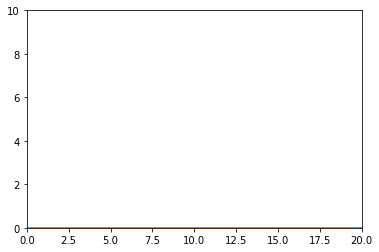

6


<Figure size 432x288 with 0 Axes>

6


<Figure size 432x288 with 0 Axes>

9


<Figure size 432x288 with 0 Axes>

5


<Figure size 432x288 with 0 Axes>

9


<Figure size 432x288 with 0 Axes>

9


<Figure size 432x288 with 0 Axes>

6


<Figure size 432x288 with 0 Axes>

1


<Figure size 432x288 with 0 Axes>

10


<Figure size 432x288 with 0 Axes>

8


<Figure size 432x288 with 0 Axes>

7


<Figure size 432x288 with 0 Axes>

8


<Figure size 432x288 with 0 Axes>

2


<Figure size 432x288 with 0 Axes>

3


<Figure size 432x288 with 0 Axes>

2


<Figure size 432x288 with 0 Axes>

8


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [44]:
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import numpy as np

# simulates input from serial port
def random_gen():
    while True:
        val = random.randint(1,10)
        yield val
        time.sleep(0.1)


a1 = deque([0]*100)
ax = plt.axes(xlim=(0, 20), ylim=(0, 10))
d = random_gen()

line, = plt.plot(a1)
plt.ion()
plt.ylim([0,10])
plt.show()

for i in range(0,20):
    a1.appendleft(next(d))
    datatoplot = a1.pop()
    line.set_ydata(a1)
    plt.draw()
    print(a1[0])
    i += 1
    time.sleep(0.1)
    plt.pause(0.0001) 
    plt.show()

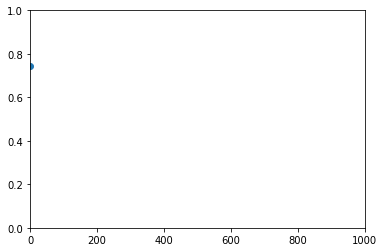

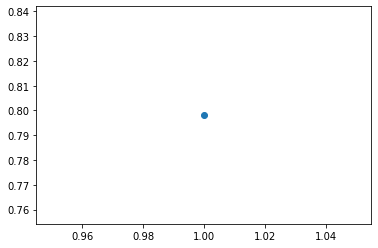

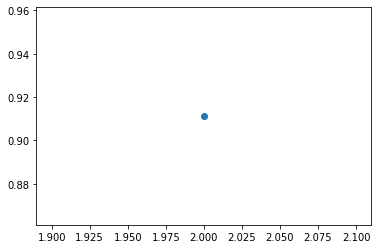

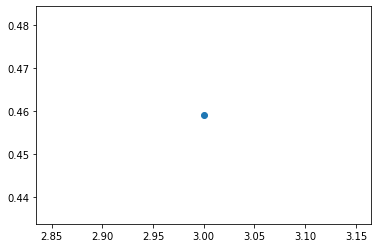

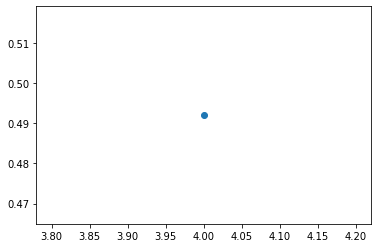

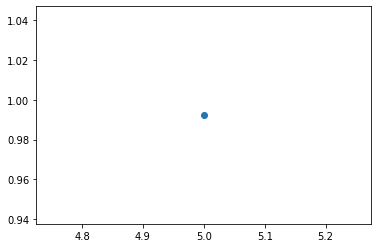

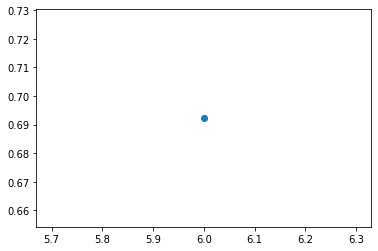

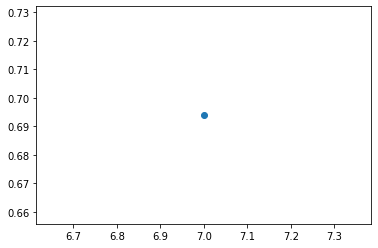

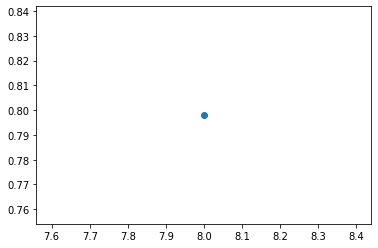

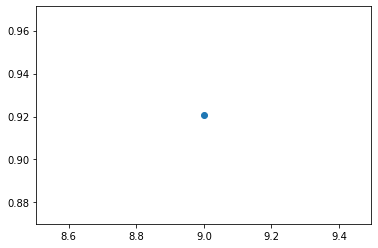

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.ion() ## Note this correction
fig=plt.figure()
plt.axis([0,1000,0,1])

i=0
x=list()
y=list()

while i <10:
    temp_y=np.random.random();
    x.append(i);
    y.append(temp_y);
    plt.scatter(i,temp_y);
    i+=1;
    plt.show()
    plt.pause(0.0001) #Note this correction

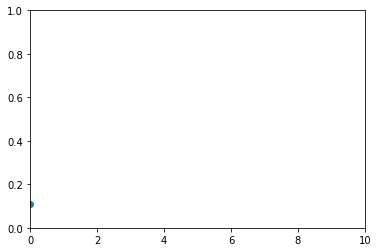

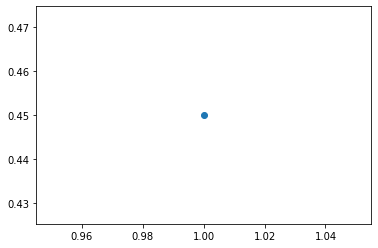

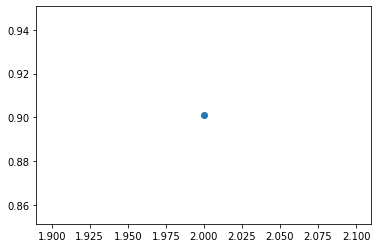

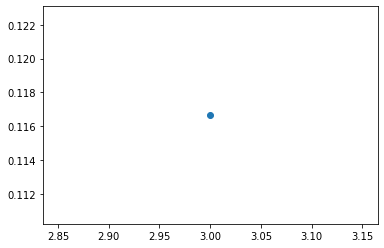

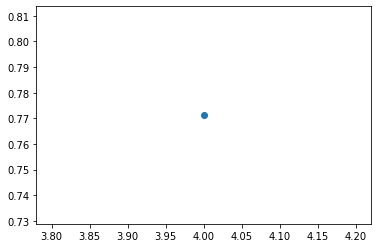

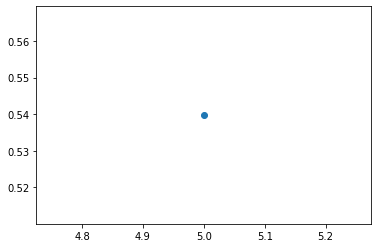

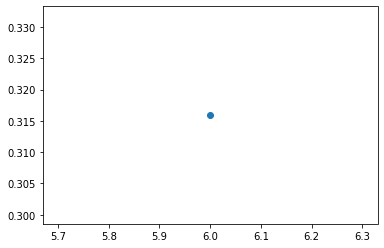

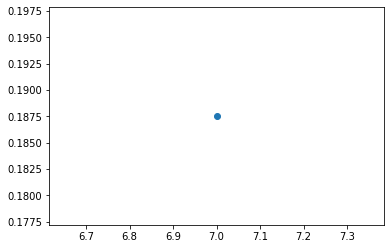

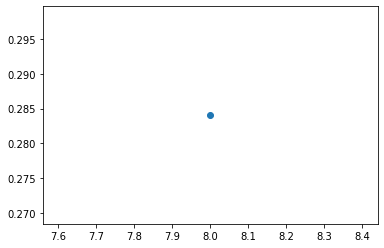

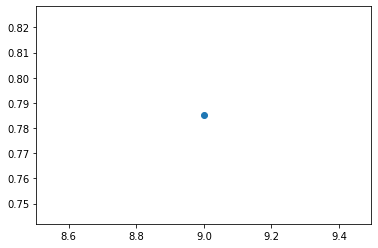

In [41]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.axis([0, 10, 0, 1])

for i in range(10):
    y = np.random.random()
    plt.scatter(i, y)
    plt.pause(0.1)

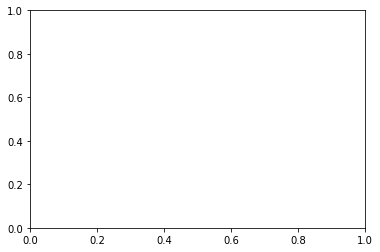

In [33]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    pullData = open("sample_data.txt","r").read()
    dataArray = pullData.split('\n')
    xar = []
    yar = []
    for eachLine in dataArray:
        if len(eachLine)>1:
            x,y = eachLine.split(',')
            xar.append(int(x))
            yar.append(int(y))
    ax1.clear()
    ax1.plot(xar,yar)
ani = animation.FuncAnimation(fig, animate, interval=10)
plt.show()

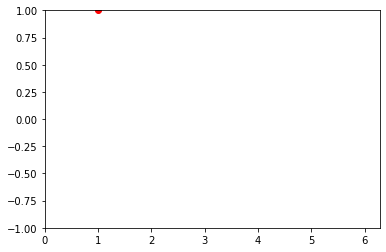

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [1,2,3], [1,2,3]
ln, = plt.plot([1,2,3], [1,2,3], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

Line2D(_line0)


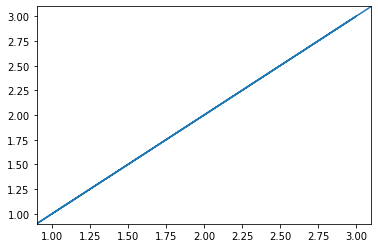

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy

def update_line(hl, new_data):
    hl.set_xdata(numpy.append(hl.get_xdata(), new_data))
    hl.set_ydata(numpy.append(hl.get_ydata(), new_data))
#     ax.relim()
#     ax.autoscale_view()
    plt.draw()
    
hl, = plt.plot([1,2,3], [1,2,3])

for num in range(50):
    update_line(hl, num)
print(hl)

C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


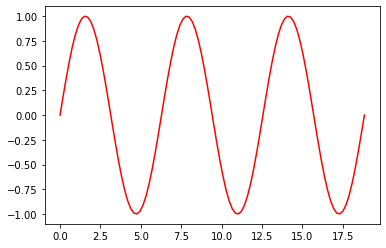

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 6*np.pi, 100)
y = np.sin(x)

# You probably won't need this if you're embedding things in a tkinter plot...
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'r-') # Returns a tuple of line objects, thus the comma

for phase in np.linspace(0, 10*np.pi, 500):
    line1.set_ydata(np.sin(x + phase))
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.show()

In [13]:
for metabolite in model.metabolites:
    for reaction in model.reactions:
        if metabolite in reaction.metabolites:
            print(reaction.metabolites[metabolite] * solution.fluxes[reaction.id])

0.0
-1.0952885208073062
1.0952885208073062
-0.0
0.004741508748084825
-0.004741508748084825
-0.004741508748084825
0.004741508748084825
-0.0
-0.0
0.0
-0.0
0.0
-0.0
-0.9024671650519063
23.20991996333199
-0.0
-22.307452798280085
0.0
-0.0
-96.36916046845965
96.36916046845965
0.0
-0.0
-0.0
0.0
0.001580502916027839
-0.003161005832055678
0.001580502916027839
1.3544909990361234
-1.3544909990361234
-0.025288046656445712
0.025288046656445712
0.001580502916027839
-0.001580502916027839
-0.001580502916027839
0.001580502916027839
1.3544909990361234
-1.3544909990361234
-0.004741508748083571
0.004741508748083571
-0.001580502916027857
0.001580502916027857
-1.5836639218601627
0.0
-1.3544909990361234
2.939735423812314
-0.0
-0.0
-0.001580502916027857
0.001580502916027857
-0.001580502916027857
0.0
-0.001580502916027857
0.001580502916027857
-0.001580502916027857
0.001580502916027857
0.4346383019076607
0.001580502916027857
0.0
-45.94205876309862
0.0
0.0
0.0
0.0
0.70806530638048
0.0
0.0
0.0
0.0
0.0252880466564

1696.2768697511522
-0.0
-0.0
-233.53564824326762
0.0
-0.025288046656445712
-0.009483017496167142
-94.12168532186803
-0.0
0.0
396.9315787007147
2.939735423812314
-0.0
-27.079110651008758
-93.4104590096555
0.0
0.0
-0.0
-0.0
-0.0
-1.0952885208073062
-0.0
0.0
-1.303914905722982
-0.8487300659069592
-0.28132951905295855
-129.5405336410027
-0.0
-181.74760215580335
-3.350186214853518
-79.14814932591436
-9.073420998561609
-118.25951004409431
-553.2975499043715
-0.0
-27.72817663700549
-0.0
-0.0
-23.67478661630096
-0.0
-0.0
-125.77802152644787
-293.48457903304404
-0.004741508748083571
0.004741508748083571
1.3544909990361234
0.0
-495.24518208931346
493.0419610243701
0.848730065907208
94.12168532186803
-0.0
-94.12168532186803
-0.0
-55.63477738616346
55.63477738616346
0.0
898.5598583498364
0.0
-1562.055195302301
-0.0
0.634308503632629
0.0
0.20072387033553782
-0.634308503632629
-1.7295970244399352
665.0242101065688
-0.0
-0.0
-0.0
-0.0
0.0
-0.0
-0.0
-0.0
0.0
-0.0
-0.0
0.0
-0.0
-0.0
-0.0
-0.0
-0.907342

In [10]:
solution = model.optimize()
solution.fluxes

ADMDC        0.001581
CO2t     -2390.521857
CSNt2        1.205924
CYSabc       0.000000
DAPE         2.046751
             ...     
KAS11       10.481502
KAS12       24.457048
OIVD3       92.768775
OIVD1r      22.307453
OIVD2        3.218023
Name: fluxes, Length: 743, dtype: float64

In [5]:
entries = {'id':{'flux':flux, 'temperature_deviation':temperature_deviation, 'ph_deviation':ph_deviation}}

print(list(entries.values()['flux'])[0])

NameError: name 'flux' is not defined

In [4]:
entries = {'id_1':{'temperature_deviation':24}, 
           'id_2':{'temperature_deviation':26}}

deviations = [entries[entry]['temperature_deviation'] for entry in entries]
print(deviations)

[24, 26]
